# **Final project (predicting reorders & time-to-next-order from Instacart shopping history)**

## **Phase 1: Setup & Data Loading**

###**Step 1: Import Required Libraries**

In [109]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score,
                             confusion_matrix, classification_report, mean_absolute_error,
                             mean_squared_error, r2_score)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import learning_curve
import shap

### **Step 2: Load the Dataset**

In [32]:
orders = pd.read_csv('/content/orders.csv')
order_products_prior = pd.read_csv('/content/order_products__prior.csv')
order_products_train = pd.read_csv('/content/order_products__train.csv')
products = pd.read_csv('/content/products.csv')
aisles = pd.read_csv('/content/aisles.csv')
departments = pd.read_csv('/content/departments.csv')

## **Phase 2: Exploratory Data Analysis (EDA)**

### **Step 1: View The Data**

In [33]:
# Display first rows of each dataset
print("="*80)
print("ORDERS DATASET")
print("="*80)
display(orders.head())

print("\n" + "="*80)
print("ORDER PRODUCTS (PRIOR) DATASET")
print("="*80)
display(order_products_prior.head())

print("\n" + "="*80)
print("ORDER PRODUCTS (TRAIN) DATASET")
print("="*80)
display(order_products_train.head())

print("\n" + "="*80)
print("PRODUCTS DATASET")
print("="*80)
display(products.head())

print("\n" + "="*80)
print("AISLES DATASET")
print("="*80)
display(aisles.head())

print("\n" + "="*80)
print("DEPARTMENTS DATASET")
print("="*80)
display(departments.head())

ORDERS DATASET


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior           1.0        2.0                8.0   
1   2398795        1    prior           2.0        3.0                7.0   
2    473747        1    prior           3.0        3.0               12.0   
3   2254736        1    prior           4.0        4.0                7.0   
4    431534        1    prior           5.0        4.0               15.0   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0


ORDER PRODUCTS (PRIOR) DATASET


order_id  product_id  add_to_cart_order  reordered
0         2     33120.0                1.0        1.0
1         2     28985.0                2.0        1.0
2         2      9327.0                3.0        0.0
3         2     45918.0                4.0        1.0
4         2     30035.0                5.0        0.0


ORDER PRODUCTS (TRAIN) DATASET


order_id  product_id  add_to_cart_order  reordered
0         1     49302.0                1.0        1.0
1         1     11109.0                2.0        1.0
2         1     10246.0                3.0        0.0
3         1     49683.0                4.0        0.0
4         1     43633.0                5.0        1.0


PRODUCTS DATASET


product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13


AISLES DATASET


aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation


DEPARTMENTS DATASET


department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [34]:
# Get info about orders dataset
print("="*80)
print("ORDERS INFO")
print("="*80)
orders.info()

# Statistical summary
print("="*80)
print("ORDERS DESCRIBE")
print("="*80)
orders.describe()

ORDERS INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473473 entries, 0 to 473472
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                473473 non-null  int64  
 1   user_id                 473473 non-null  int64  
 2   eval_set                473473 non-null  object 
 3   order_number            473472 non-null  float64
 4   order_dow               473472 non-null  float64
 5   order_hour_of_day       473472 non-null  float64
 6   days_since_prior_order  444930 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 25.3+ MB
ORDERS DESCRIBE


order_id        user_id   order_number      order_dow  \
count  4.734730e+05  473473.000000  473472.000000  473472.000000   
mean   1.710561e+06   14296.299838      17.221149       2.787753   
std    9.876466e+05    8217.428517      17.850260       2.046047   
min    6.000000e+00       1.000000       1.000000       0.000000   
25%    8.566210e+05    7165.000000       5.000000       1.000000   
50%    1.709398e+06   14367.000000      11.000000       3.000000   
75%    2.565995e+06   21462.000000      23.000000       5.000000   
max    3.421083e+06   28542.000000     100.000000       6.000000   

       order_hour_of_day  days_since_prior_order  
count      473472.000000           444930.000000  
mean           13.457482               11.089686  
std             4.208468                9.182761  
min             0.000000                0.000000  
25%            10.000000                4.000000  
50%            13.000000                7.000000  
75%            16.000000               15.000000  
max            23.000000               30.000000

In [35]:
# Shape of our datasets
print("📊 Dataset Shapes:")
print(f"Orders: {orders.shape}")
print(f"Order Products (Prior): {order_products_prior.shape}")
print(f"Order Products (Train): {order_products_train.shape}")
print(f"Products: {products.shape}")
print(f"Aisles: {aisles.shape}")
print(f"Departments: {departments.shape}")

📊 Dataset Shapes:
Orders: (473473, 7)
Order Products (Prior): (916605, 4)
Order Products (Train): (891518, 4)
Products: (49688, 4)
Aisles: (134, 2)
Departments: (21, 2)


### **Step 2: Join All Data Together**

In [36]:
print("🔗 Starting data joining process...\n")

# Separate orders by eval_set
prior_orders = orders[orders['eval_set'] == 'prior']
train_orders = orders[orders['eval_set'] == 'train']

print(f"Prior orders: {len(prior_orders):,}")
print(f"Train orders: {len(train_orders):,}")

# Join prior orders with their products
print("\n🔗 Joining prior orders with products...")
df = prior_orders.merge(order_products_prior, on='order_id', how='inner')
print(f"   After merge: {df.shape}")

# Add product information
print("🔗 Adding product details...")
df = df.merge(products, on='product_id', how='left')
print(f"   After merge: {df.shape}")

# Add aisle information
print("🔗 Adding aisle information...")
df = df.merge(aisles, on='aisle_id', how='left')
print(f"   After merge: {df.shape}")

# Add department information
print("🔗 Adding department information...")
df = df.merge(departments, on='department_id', how='left')
print(f"   Final shape: {df.shape}")

print("\n✅ All data joined successfully!")
display(df.head())

🔗 Starting data joining process...

Prior orders: 444,931
Train orders: 18,178

🔗 Joining prior orders with products...
   After merge: (127604, 10)
🔗 Adding product details...
   After merge: (127604, 13)
🔗 Adding aisle information...
   After merge: (127604, 14)
🔗 Adding department information...
   Final shape: (127604, 15)

✅ All data joined successfully!


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0     94891        4    prior           4.0        5.0               13.0   
1     94891        4    prior           4.0        5.0               13.0   
2     23391        7    prior          17.0        0.0               10.0   
3     23391        7    prior          17.0        0.0               10.0   
4     23391        7    prior          17.0        0.0               10.0   

   days_since_prior_order  product_id  add_to_cart_order  reordered  \
0                    15.0     22199.0                1.0        0.0   
1                    15.0     25146.0                2.0        0.0   
2                    28.0     13198.0                1.0        1.0   
3                    28.0     42803.0                2.0        1.0   
4                    28.0      8277.0                3.0        1.0   

               product_name  aisle_id  department_id  \
0            Extra-Dry Cava       134              5   
1     Original Orange Juice        31              7   
2      85% Lean Ground Beef       122             12   
3      Organic Apple Slices        50             19   
4  Apple Honeycrisp Organic        24              4   

                        aisle    department  
0  specialty wines champagnes       alcohol  
1                refrigerated     beverages  
2                meat counter  meat seafood  
3      fruit vegetable snacks        snacks  
4                fresh fruits       produce

### **Step 3: Basic Dataset Statistics**

In [37]:
print("="*80)
print("📊 DATASET INFORMATION")
print("="*80)

stats = {
    'Total records': len(df),
    'Total features': len(df.columns),
    'Unique users': df['user_id'].nunique(),
    'Unique products': df['product_id'].nunique(),
    'Unique orders': df['order_id'].nunique(),
    'Unique aisles': df['aisle'].nunique(),
    'Unique departments': df['department'].nunique()
}

for key, value in stats.items():
    print(f"{key}: {value:,}")

📊 DATASET INFORMATION
Total records: 127,604
Total features: 15
Unique users: 8,761
Unique products: 17,597
Unique orders: 12,650
Unique aisles: 134
Unique departments: 21


### **Step 4: Target Variable Analysis (recorded vs not recorded)**

In [38]:
# Count 0s and 1s
reorder_counts = df['reordered'].value_counts()
total = len(df)

print(f"\nNot Reordered (0): {reorder_counts[0]:,} ({reorder_counts[0]/total*100:.2f}%)")
print(f"Reordered (1): {reorder_counts[1]:,} ({reorder_counts[1]/total*100:.2f}%)")

# Check balance
ratio = reorder_counts[0] / reorder_counts[1]
print(f"\nImbalance Ratio: {ratio:.2f}:1")

if ratio > 1.5:
    print("⚠️ Dataset is imbalanced!")
else:
    print("✅ Dataset is balanced!")


Not Reordered (0): 51,647 (40.47%)
Reordered (1): 75,957 (59.53%)

Imbalance Ratio: 0.68:1
✅ Dataset is balanced!


### **Step 5: Visualize Class Imbalance**

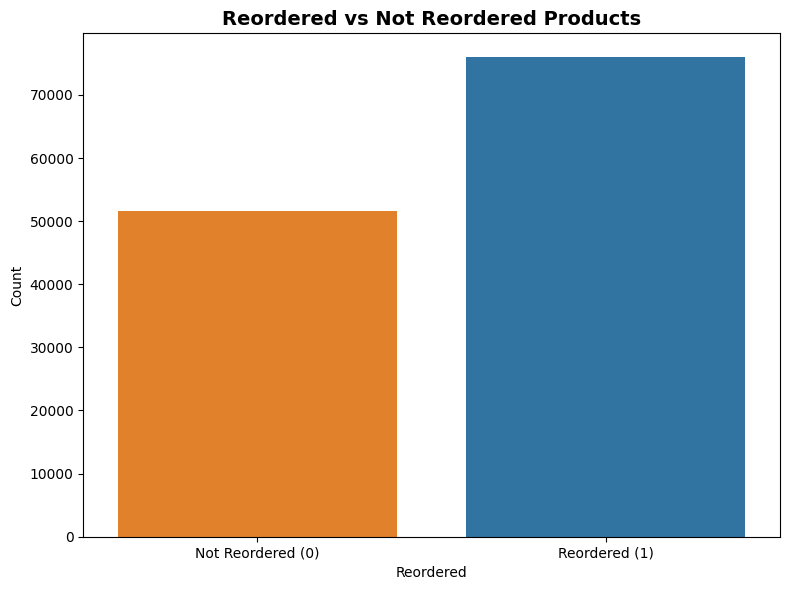

In [39]:
# Bar plot for reordered vs not reordered
plt.figure(figsize=(8, 6))
sns.countplot(x='reordered', data=df, palette=['#ff7f0e', '#1f77b4'])
plt.title('Reordered vs Not Reordered Products', fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['Not Reordered (0)', 'Reordered (1)'])
plt.ylabel('Count')
plt.xlabel('Reordered')
plt.tight_layout()
plt.show()

### **Step 6: Time patterns analysis**

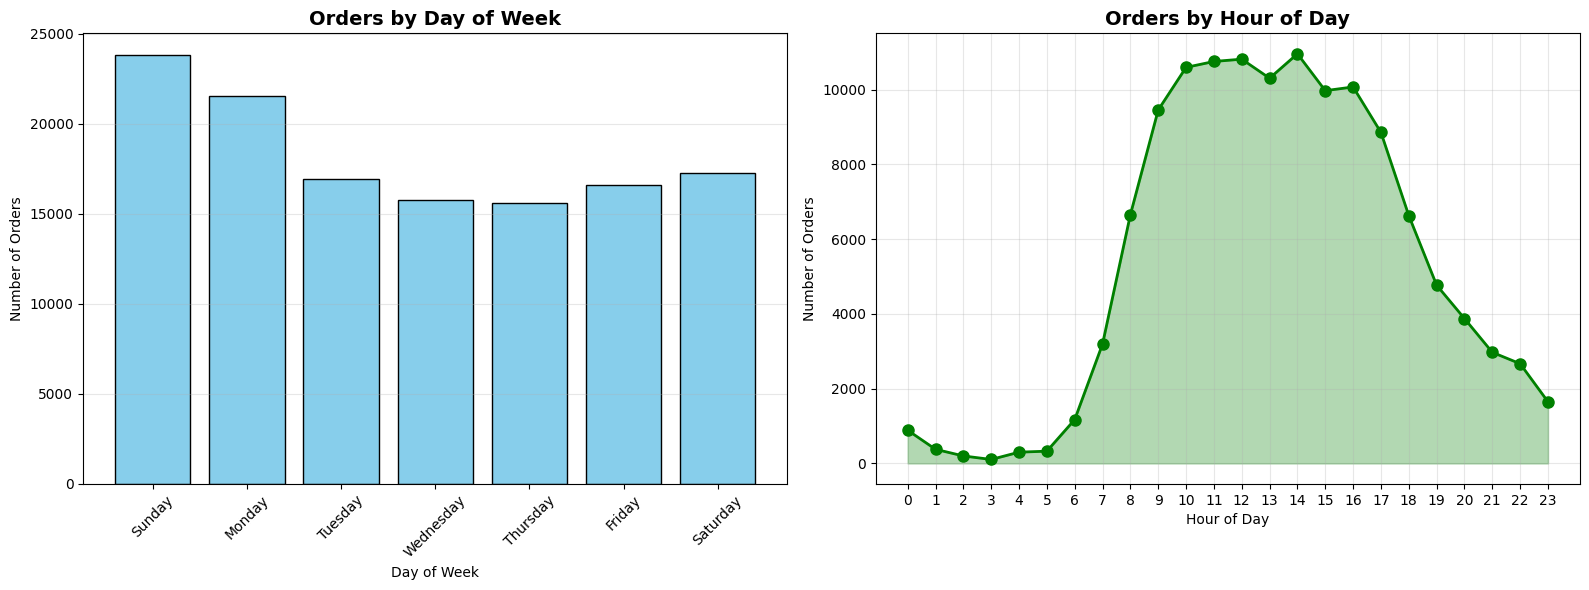

In [40]:
day_counts = df['order_dow'].value_counts().sort_index()
hour_counts = df['order_hour_of_day'].value_counts().sort_index()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Day of week
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
axes[0].bar(days, day_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('Orders by Day of Week', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Orders')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Hour of day
axes[1].plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2,
             markersize=8, color='green')
axes[1].fill_between(hour_counts.index, hour_counts.values, alpha=0.3, color='green')
axes[1].set_title('Orders by Hour of Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Orders')
axes[1].set_xticks(range(0, 24))
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### **Step 7: Top Categories Analysis**

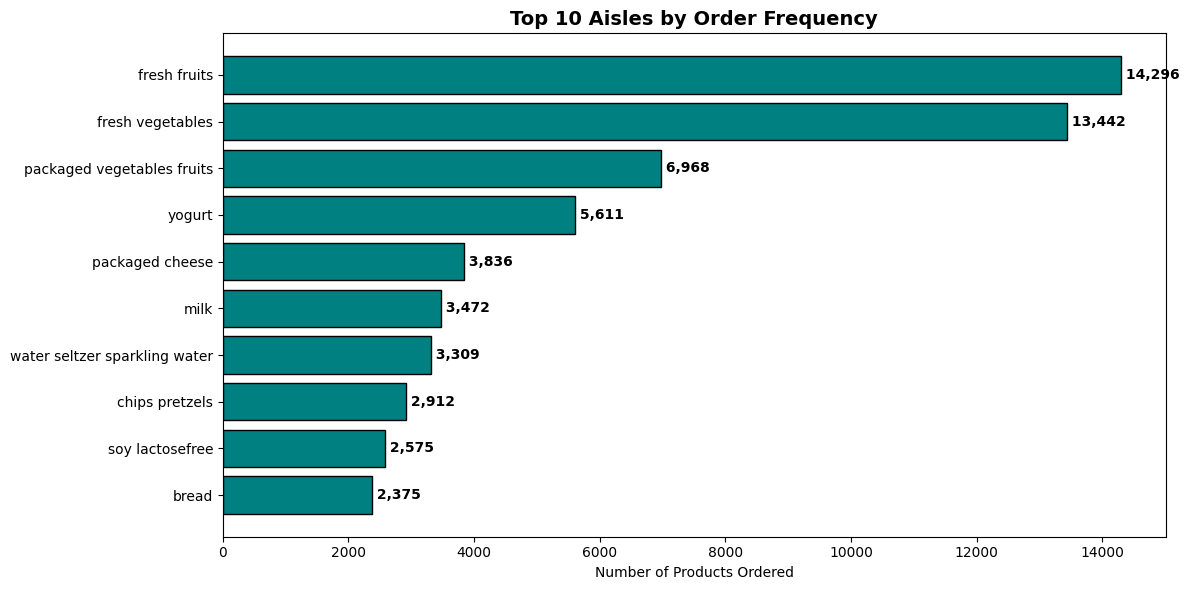

In [41]:
# Top 10 Aisles
top_aisles = df['aisle'].value_counts().head(10)
plt.figure(figsize=(12, 6))
plt.barh(range(10), top_aisles.values, color='teal', edgecolor='black')
plt.yticks(range(10), top_aisles.index)
plt.xlabel('Number of Products Ordered')
plt.title('Top 10 Aisles by Order Frequency', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, v in enumerate(top_aisles.values):
    plt.text(v, i, f' {v:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

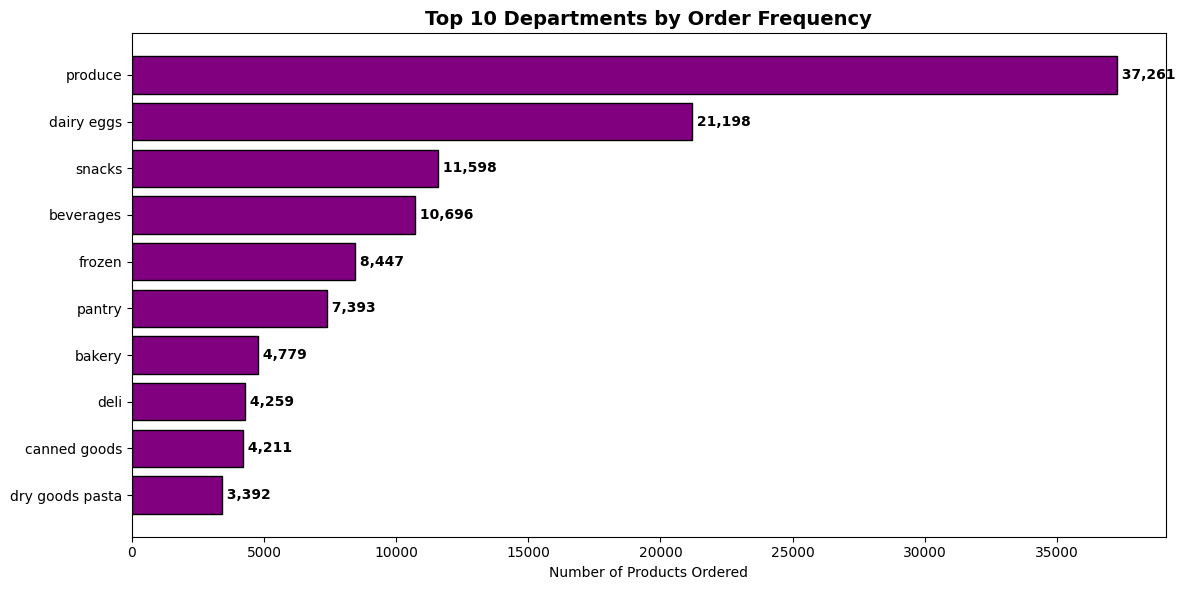

In [42]:
# Top 10 Departments
top_depts = df['department'].value_counts().head(10)
plt.figure(figsize=(12, 6))
plt.barh(range(10), top_depts.values, color='purple', edgecolor='black')
plt.yticks(range(10), top_depts.index)
plt.xlabel('Number of Products Ordered')
plt.title('Top 10 Departments by Order Frequency', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, v in enumerate(top_depts.values):
    plt.text(v, i, f' {v:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### **Step 8: Top Product analysis**

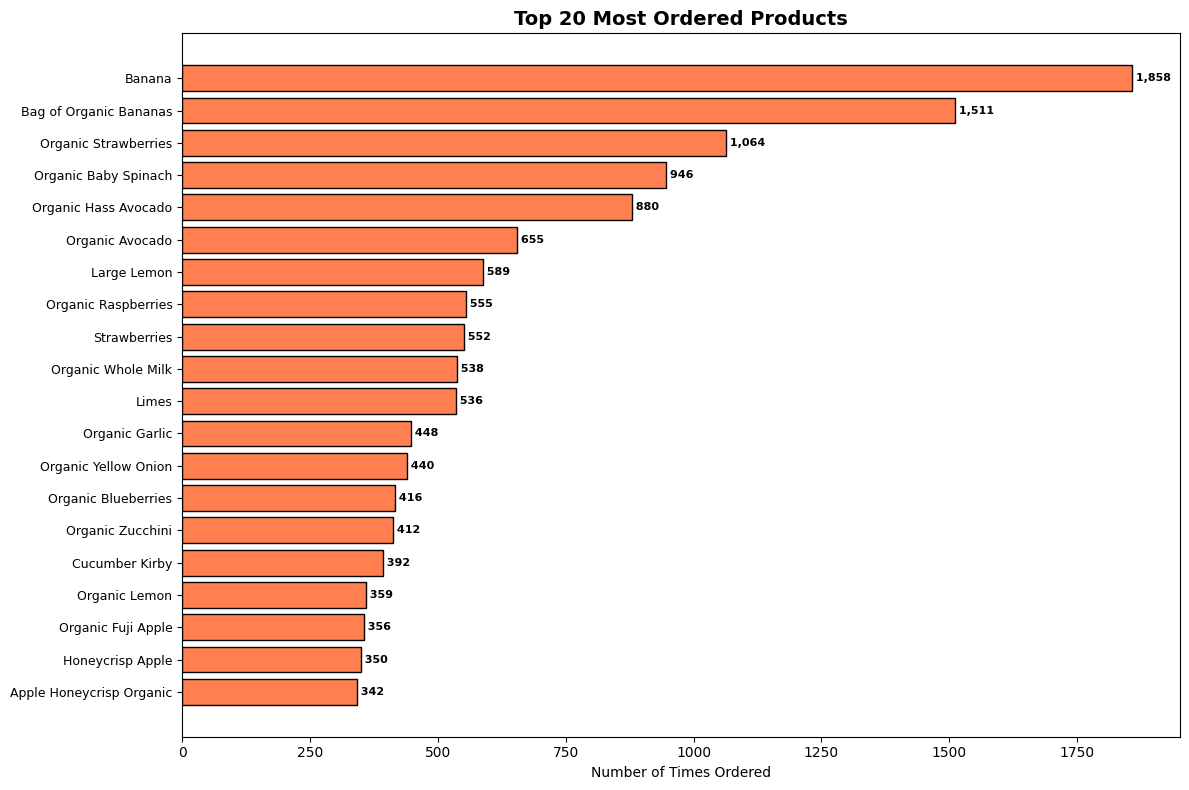

In [43]:
# Top 20 Most Ordered Products
top_products = df['product_name'].value_counts().head(20)
plt.figure(figsize=(12, 8))
plt.barh(range(20), top_products.values, color='coral', edgecolor='black')
plt.yticks(range(20), top_products.index, fontsize=9)
plt.xlabel('Number of Times Ordered')
plt.title('Top 20 Most Ordered Products', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, v in enumerate(top_products.values):
    plt.text(v, i, f' {v:,}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

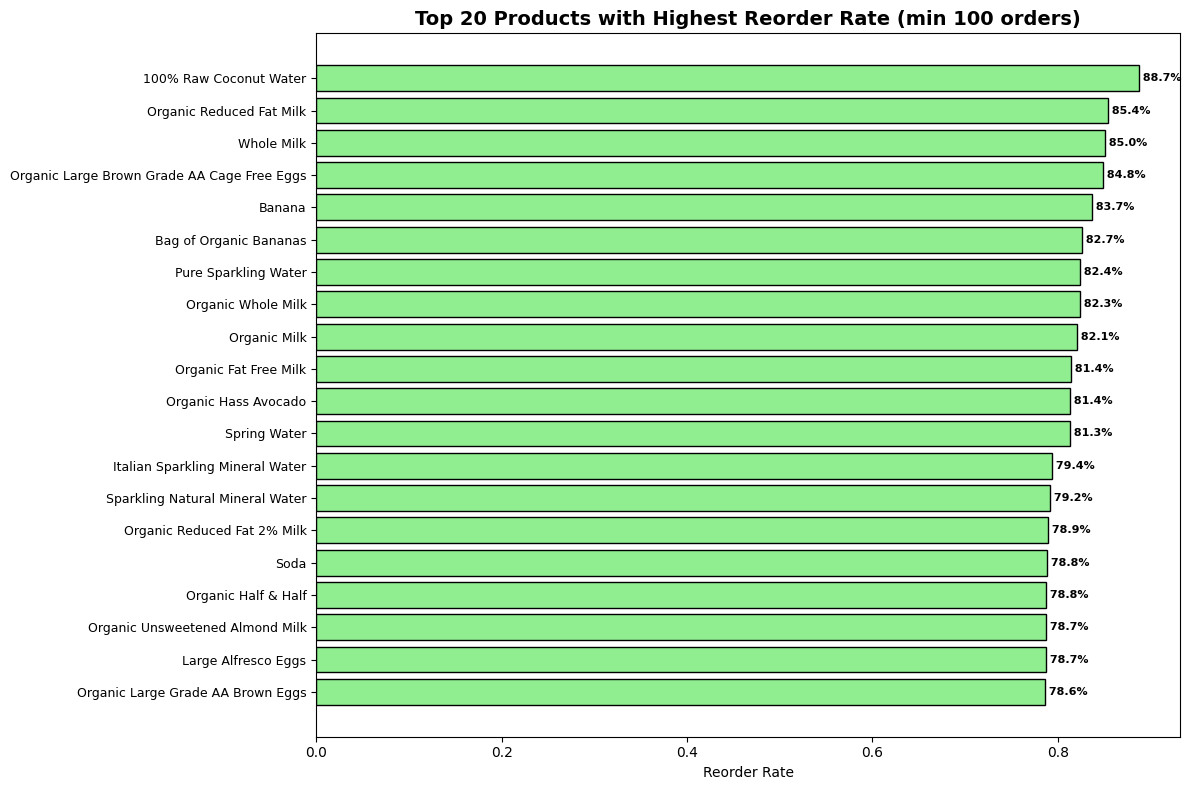

In [44]:
# Calculate reorder rate per product
product_reorder = df.groupby('product_name')['reordered'].agg(['sum', 'count'])
product_reorder['reorder_rate'] = product_reorder['sum'] / product_reorder['count']

# Filter products with at least 100 orders
product_reorder = product_reorder[product_reorder['count'] >= 100]
top_reorder_products = product_reorder.sort_values('reorder_rate', ascending=False).head(20)

# Get actual number of products
num_products = len(top_reorder_products)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(num_products), top_reorder_products['reorder_rate'].values,
         color='lightgreen', edgecolor='black')
plt.yticks(range(num_products), top_reorder_products.index, fontsize=9)
plt.xlabel('Reorder Rate')
plt.title(f'Top {num_products} Products with Highest Reorder Rate (min 100 orders)',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add percentage labels
for i, v in enumerate(top_reorder_products['reorder_rate'].values):
    plt.text(v, i, f' {v*100:.1f}%', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

### **Step 9: Correlation matrix**

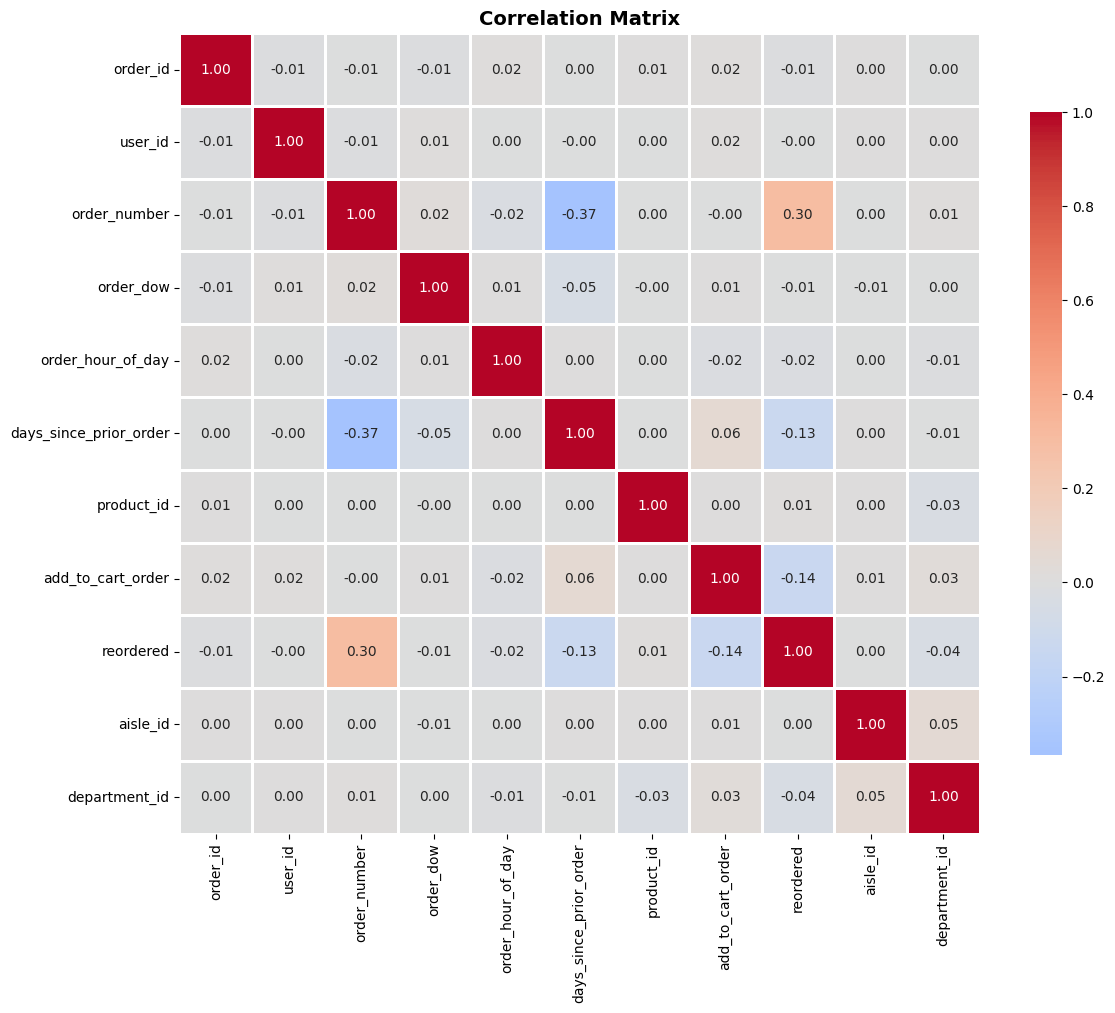

In [45]:
# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_data = df[numeric_cols]

# Calculate correlation matrix
corr_matrix = numeric_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [46]:
# Top correlations with 'reordered'
print("🔍 TOP CORRELATIONS WITH 'REORDERED'")
print("="*80)
print("\n📈 Positive Correlations:")
print(corr_matrix['reordered'].sort_values(ascending=False)[1:6])

print("\n📉 Negative Correlations:")
print(corr_matrix['reordered'].sort_values()[:5])

🔍 TOP CORRELATIONS WITH 'REORDERED'

📈 Positive Correlations:
order_number    0.303600
product_id      0.008230
aisle_id        0.001734
user_id        -0.001499
order_dow      -0.006614
Name: reordered, dtype: float64

📉 Negative Correlations:
add_to_cart_order        -0.136824
days_since_prior_order   -0.132429
department_id            -0.039585
order_hour_of_day        -0.022095
order_id                 -0.009455
Name: reordered, dtype: float64


## **Phase 3: Data Preprocessing**

### **Step 1: Check for Missing Values**

In [47]:
df.isnull().sum()

order_id                     0
user_id                      0
eval_set                     0
order_number                 0
order_dow                    0
order_hour_of_day            0
days_since_prior_order    8147
product_id                   0
add_to_cart_order            0
reordered                    0
product_name                 0
aisle_id                     0
department_id                0
aisle                        0
department                   0
dtype: int64

### **Step 2: Handle Missing Values**

In [48]:
df.fillna(0, inplace=True)
print("✅ Missing values filled")

✅ Missing values filled


### **Step 3: Check Duplicates**

In [49]:
df.duplicated().sum()

np.int64(0)

**No Dublicated Values**

##**Phase 4: Feature Engineering**

### **Step 1: Creating All Features**

In [50]:
# ===== USER FEATURES =====
print("\n1️⃣ User Features...")
user_features = df.groupby('user_id').agg({
    'order_id': 'nunique',
    'product_id': 'count',
    'reordered': 'mean',
    'days_since_prior_order': 'mean'
}).reset_index()

user_features.columns = ['user_id', 'user_total_orders', 'user_total_products',
                         'user_reorder_ratio', 'user_avg_days_between']
user_features['user_avg_basket_size'] = user_features['user_total_products'] / user_features['user_total_orders']

print(f"   Created {len(user_features.columns)-1} user features ✓")


# ===== PRODUCT FEATURES =====
print("\n2️⃣ Product Features...")
product_features = df.groupby('product_id').agg({
    'reordered': 'mean',
    'add_to_cart_order': 'mean',
    'order_id': 'count'
}).reset_index()

product_features.columns = ['product_id', 'product_reorder_rate',
                            'product_avg_position', 'product_popularity']

print(f"   Created {len(product_features.columns)-1} product features ✓")


# ===== USER × PRODUCT FEATURES =====
print("\n3️⃣ User × Product Features...")
user_product_features = df.groupby(['user_id', 'product_id']).agg({
    'order_id': 'count',
    'reordered': 'mean'
}).reset_index()

user_product_features.columns = ['user_id', 'product_id',
                                  'user_product_count', 'user_product_reorder_rate']

print(f"   Created {len(user_product_features.columns)-2} user×product features ✓")


# ===== TEMPORAL FEATURES =====
print("\n4️⃣ Temporal Features...")
df['is_weekend'] = (df['order_dow'] >= 5).astype(int)
df['is_morning'] = ((df['order_hour_of_day'] >= 6) & (df['order_hour_of_day'] < 12)).astype(int)
df['is_afternoon'] = ((df['order_hour_of_day'] >= 12) & (df['order_hour_of_day'] < 18)).astype(int)
df['is_evening'] = (df['order_hour_of_day'] >= 18).astype(int)

print(f"   Created 4 temporal features ✓")


# ===== ADVANCED FEATURES =====
print("\n5️⃣ Advanced Features...")
df['log_days_since_prior'] = np.log1p(df['days_since_prior_order'])
df['log_order_number'] = np.log1p(df['order_number'])
df['order_dow_hour'] = df['order_dow'] * df['order_hour_of_day']

print(f"   Created 3 advanced features ✓")


# ===== MERGE ALL =====
print("\n🔗 Merging all features...")
df = df.merge(user_features, on='user_id', how='left')
df = df.merge(product_features, on='product_id', how='left')
df = df.merge(user_product_features, on=['user_id', 'product_id'], how='left')

print(f"\n✅ Feature Engineering Complete!")
print(f"Final shape: {df.shape}")


1️⃣ User Features...
   Created 5 user features ✓

2️⃣ Product Features...
   Created 3 product features ✓

3️⃣ User × Product Features...
   Created 2 user×product features ✓

4️⃣ Temporal Features...
   Created 4 temporal features ✓

5️⃣ Advanced Features...
   Created 3 advanced features ✓

🔗 Merging all features...

✅ Feature Engineering Complete!
Final shape: (127604, 32)


### **Step 2: Encoding Categorical Variables**

In [51]:
# ===== 1. ONE-HOT ENCODING =====
print("\n1️⃣ One-Hot Encoding...")
df['is_weekend'] = (df['order_dow'] >= 5).astype(int)
print("   Encoded: weekend ✓")


# ===== 2. FREQUENCY ENCODING =====
print("\n2️⃣ Frequency Encoding...")
df['aisle_freq'] = df.groupby('aisle')['aisle'].transform('count') / len(df)
df['department_freq'] = df.groupby('department')['department'].transform('count') / len(df)
print("   Encoded: aisle, department ✓")


# ===== 3. TARGET ENCODING =====
print("\n3️⃣ Target Encoding (with smoothing)...")
global_mean = df['reordered'].mean()
product_mean = df.groupby('product_id')['reordered'].transform('mean')
product_count = df.groupby('product_id')['product_id'].transform('count')

smoothing = 10
df['product_target_enc'] = (product_mean * product_count + global_mean * smoothing) / (product_count + smoothing)
print("   Encoded: product_id ✓")


print("\n✅ Encoding Complete!")
print(f"New columns: is_weekend, aisle_freq, department_freq, product_target_enc")


1️⃣ One-Hot Encoding...
   Encoded: weekend ✓

2️⃣ Frequency Encoding...
   Encoded: aisle, department ✓

3️⃣ Target Encoding (with smoothing)...
   Encoded: product_id ✓

✅ Encoding Complete!
New columns: is_weekend, aisle_freq, department_freq, product_target_enc


**Feature Engineering Summary**

In [52]:
print(f"\nFinal dataset shape: {df.shape}")
print(f"Total features: {len(df.columns)}")

print("\n✅ Features created:")
print("  • User-level: 5 features")
print("  • Product-level: 3 features")
print("  • User×Product: 2 features")
print("  • Temporal: 6 features")
print("  • Advanced: 4 features")
print("  • Encoded: 3 types (one-hot, frequency, target)")


Final dataset shape: (127604, 35)
Total features: 35

✅ Features created:
  • User-level: 5 features
  • Product-level: 3 features
  • User×Product: 2 features
  • Temporal: 6 features
  • Advanced: 4 features
  • Encoded: 3 types (one-hot, frequency, target)


**Check Final Data**

In [53]:
# Check for missing values after feature engineering
print(f"\nMissing values: {df.isnull().sum().sum()}\n")

# Display sample
display(df.head())


Missing values: 0



order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0     94891        4    prior           4.0        5.0               13.0   
1     94891        4    prior           4.0        5.0               13.0   
2     23391        7    prior          17.0        0.0               10.0   
3     23391        7    prior          17.0        0.0               10.0   
4     23391        7    prior          17.0        0.0               10.0   

   days_since_prior_order  product_id  add_to_cart_order  reordered  ...  \
0                    15.0     22199.0                1.0        0.0  ...   
1                    15.0     25146.0                2.0        0.0  ...   
2                    28.0     13198.0                1.0        1.0  ...   
3                    28.0     42803.0                2.0        1.0  ...   
4                    28.0      8277.0                3.0        1.0  ...   

  user_avg_days_between  user_avg_basket_size  product_reorder_rate  \
0                  15.0                   2.0              0.000000   
1                  15.0                   2.0              0.625000   
2                  28.0                  11.0              0.617021   
3                  28.0                  11.0              0.733333   
4                  28.0                  11.0              0.725146   

  product_avg_position product_popularity  user_product_count  \
0             1.000000                  1                   1   
1             6.715909                 88                   1   
2             8.021277                 47                   1   
3             7.500000                 30                   1   
4             7.640351                342                   1   

   user_product_reorder_rate  aisle_freq  department_freq  product_target_enc  
0                        0.0    0.000360         0.004224            0.541141  
1                        0.0    0.018369         0.083822            0.621965  
2                        1.0    0.002045         0.021324            0.613203  
3                        1.0    0.005588         0.090891            0.698814  
4                        1.0    0.112034         0.292005            0.721456  

[5 rows x 35 columns]

## **Phase 5: Train-Test Split**

In [54]:
# Sort by order_number
df_sorted = df.sort_values('order_number')

# Split: 80% early orders = train, 20% late orders = test
split_idx = int(0.8 * len(df_sorted))

train_data = df_sorted.iloc[:split_idx]
test_data = df_sorted.iloc[split_idx:]

# Prepare features and target
drop_cols = ['order_id', 'user_id', 'product_id', 'product_name',
             'aisle', 'department', 'eval_set', 'aisle_id', 'department_id', 'order_number']
drop_cols = [col for col in drop_cols if col in train_data.columns]

X_train = train_data.drop(drop_cols + ['reordered'], axis=1, errors='ignore')
y_train = train_data['reordered']

X_test = test_data.drop(drop_cols + ['reordered'], axis=1, errors='ignore')
y_test = test_data['reordered']

# Fill missing
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

print(f"Train set (early orders): {X_train.shape}")
print(f"Test set (late orders): {X_test.shape}")
print("✅ Time-aware split complete!")

Train set (early orders): (102083, 24)
Test set (late orders): (25521, 24)
✅ Time-aware split complete!


###**Class Imbalance Handling**

In [55]:
# Check imbalance
class_counts = y_train.value_counts()
print(f"\nClass distribution in training:")
print(class_counts)
print(f"\nImbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Approach 1: Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: {class_weight_dict}")

# Approach 2: Random Undersampling (undersample majority)
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
print(f"\nAfter undersampling: {pd.Series(y_train_under).value_counts()}")


Class distribution in training:
reordered
1.0    55381
0.0    46702
Name: count, dtype: int64

Imbalance ratio: 0.84:1

Class weights: {0: np.float64(1.0929189328080169), 1: np.float64(0.9216428016828876)}

After undersampling: reordered
0.0    46702
1.0    46702
Name: count, dtype: int64


### **Feature Scaling**

In [56]:
# Scale features (needed for KNN, SVM, Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale undersampled data (if you created it)
X_train_under_scaled = scaler.fit_transform(X_train_under)

print("✅ Features scaled using StandardScaler")
print(f"   Training shape: {X_train_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")
print(f"   Undersampled shape: {X_train_under_scaled.shape}")

print("   • X_train_scaled, X_test_scaled → For Logistic, SVM, KNN")
print("   • X_train_under_scaled → Undersampled (scaled)")
print("   • X_train, X_test (unscaled) → For Tree-based models (RF, DT, XGBoost)")


✅ Features scaled using StandardScaler
   Training shape: (102083, 24)
   Test shape: (25521, 24)
   Undersampled shape: (93404, 24)
   • X_train_scaled, X_test_scaled → For Logistic, SVM, KNN
   • X_train_under_scaled → Undersampled (scaled)
   • X_train, X_test (unscaled) → For Tree-based models (RF, DT, XGBoost)


##**Phase 6: Modelling**

### **Task A: Classification (Reorder Prediction)**

**Step 1: Train All Models**

In [57]:
results = {}
trained_models = {}

# ========== 1. LOGISTIC REGRESSION ==========
print("\n1️⃣ Logistic Regression")
start = time.time()
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
results['Logistic Regression'] = {'predictions': y_pred_lr, 'probabilities': y_proba_lr}
trained_models['Logistic Regression'] = lr_model
print(f"   ✅ Done in {time.time() - start:.2f}s")


# ========== 2. K-NEAREST NEIGHBORS ==========
print("\n2️⃣ K-Nearest Neighbors")
start = time.time()
knn_idx = np.random.choice(len(X_train_scaled), 50000, replace=False)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled[knn_idx], y_train.iloc[knn_idx])
y_pred_knn = knn_model.predict(X_test_scaled)
y_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]
results['KNN'] = {'predictions': y_pred_knn, 'probabilities': y_proba_knn}
trained_models['KNN'] = knn_model
print(f"   ✅ Done in {time.time() - start:.2f}s")


# ========== 3. SUPPORT VECTOR MACHINE ==========
print("\n3️⃣ SVM")
start = time.time()
svm_idx = np.random.choice(len(X_train_scaled), 50000, replace=False)
svm_model = SVC(class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_scaled[svm_idx], y_train.iloc[svm_idx])
y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]
results['SVM'] = {'predictions': y_pred_svm, 'probabilities': y_proba_svm}
trained_models['SVM'] = svm_model
print(f"   ✅ Done in {time.time() - start:.2f}s")


# ========== 4. DECISION TREE ==========
print("\n4️⃣ Decision Tree")
start = time.time()
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]
results['Decision Tree'] = {'predictions': y_pred_dt, 'probabilities': y_proba_dt}
trained_models['Decision Tree'] = dt_model
print(f"   ✅ Done in {time.time() - start:.2f}s")


# ========== 5. RANDOM FOREST ==========
print("\n5️⃣ Random Forest")
start = time.time()
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
results['Random Forest'] = {'predictions': y_pred_rf, 'probabilities': y_proba_rf}
trained_models['Random Forest'] = rf_model
print(f"   ✅ Done in {time.time() - start:.2f}s")


# ========== 6. XGBOOST ==========
print("\n6️⃣ XGBoost")
start = time.time()
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
results['XGBoost'] = {'predictions': y_pred_xgb, 'probabilities': y_proba_xgb}
trained_models['XGBoost'] = xgb_model
print(f"   ✅ Done in {time.time() - start:.2f}s")


# ========== 7. LIGHTGBM ==========
print("\n7️⃣ LightGBM")
start = time.time()
lgb_model = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]
results['LightGBM'] = {'predictions': y_pred_lgb, 'probabilities': y_proba_lgb}
trained_models['LightGBM'] = lgb_model
print(f"   ✅ Done in {time.time() - start:.2f}s")


1️⃣ Logistic Regression
   ✅ Done in 0.44s

2️⃣ K-Nearest Neighbors
   ✅ Done in 15.90s

3️⃣ SVM
   ✅ Done in 69.01s

4️⃣ Decision Tree
   ✅ Done in 0.46s

5️⃣ Random Forest
   ✅ Done in 9.99s

6️⃣ XGBoost
   ✅ Done in 1.59s

7️⃣ LightGBM
   ✅ Done in 2.30s


**Step 2: Evaluate All Models**

In [58]:
metrics_df = pd.DataFrame()

for model_name, result in results.items():
    y_pred = result['predictions']
    y_proba = result['probabilities']

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'Avg Precision': average_precision_score(y_test, y_proba),
    }

    metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics])], ignore_index=True)

# Sort by F1-Score
metrics_df = metrics_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n📋 MODEL COMPARISON TABLE:")
print("="*80)
display(metrics_df.round(4))

# Best model
best_model = metrics_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL: {best_model}")
print(f"   F1-Score: {metrics_df.iloc[0]['F1-Score']:.4f}")


📋 MODEL COMPARISON TABLE:


Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0  Logistic Regression    0.9960     0.9957  0.9993    0.9975   0.9998   
1                  SVM    0.9958     0.9959  0.9989    0.9974   0.9984   
2              XGBoost    0.9931     0.9970  0.9944    0.9957   0.9998   
3             LightGBM    0.9926     0.9971  0.9936    0.9954   0.9998   
4        Random Forest    0.9921     0.9966  0.9936    0.9951   0.9998   
5        Decision Tree    0.9915     0.9967  0.9928    0.9947   0.9895   
6                  KNN    0.9910     0.9914  0.9974    0.9944   0.9934   

   Avg Precision  
0         1.0000  
1         0.9995  
2         1.0000  
3         1.0000  
4         0.9999  
5         0.9953  
6         0.9969


🏆 BEST MODEL: Logistic Regression
   F1-Score: 0.9975


**Step 3: Visualize Model Comparison**

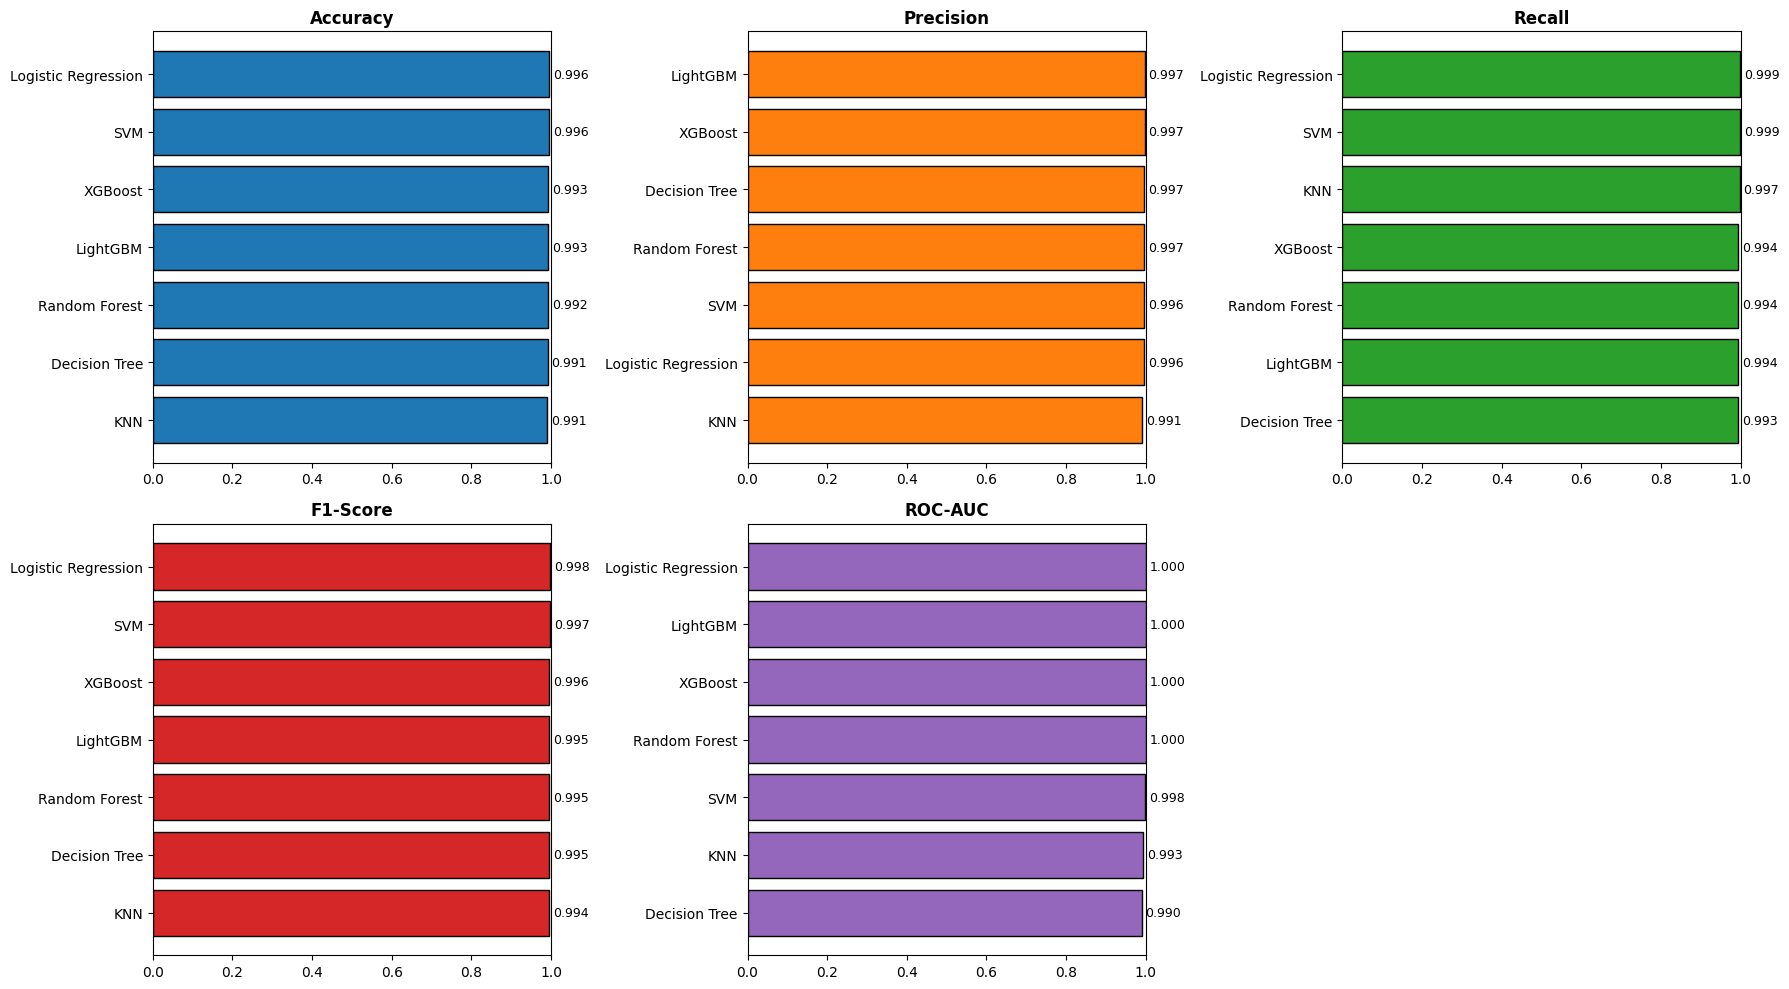

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    sorted_data = metrics_df.sort_values(metric, ascending=True)
    axes[idx].barh(sorted_data['Model'], sorted_data[metric], color=color, edgecolor='black')
    axes[idx].set_title(metric, fontsize=12, fontweight='bold')
    axes[idx].set_xlim(0, 1)

    # Add values
    for i, v in enumerate(sorted_data[metric]):
        axes[idx].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Remove last subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

**Step 4: Confusion Matrices**

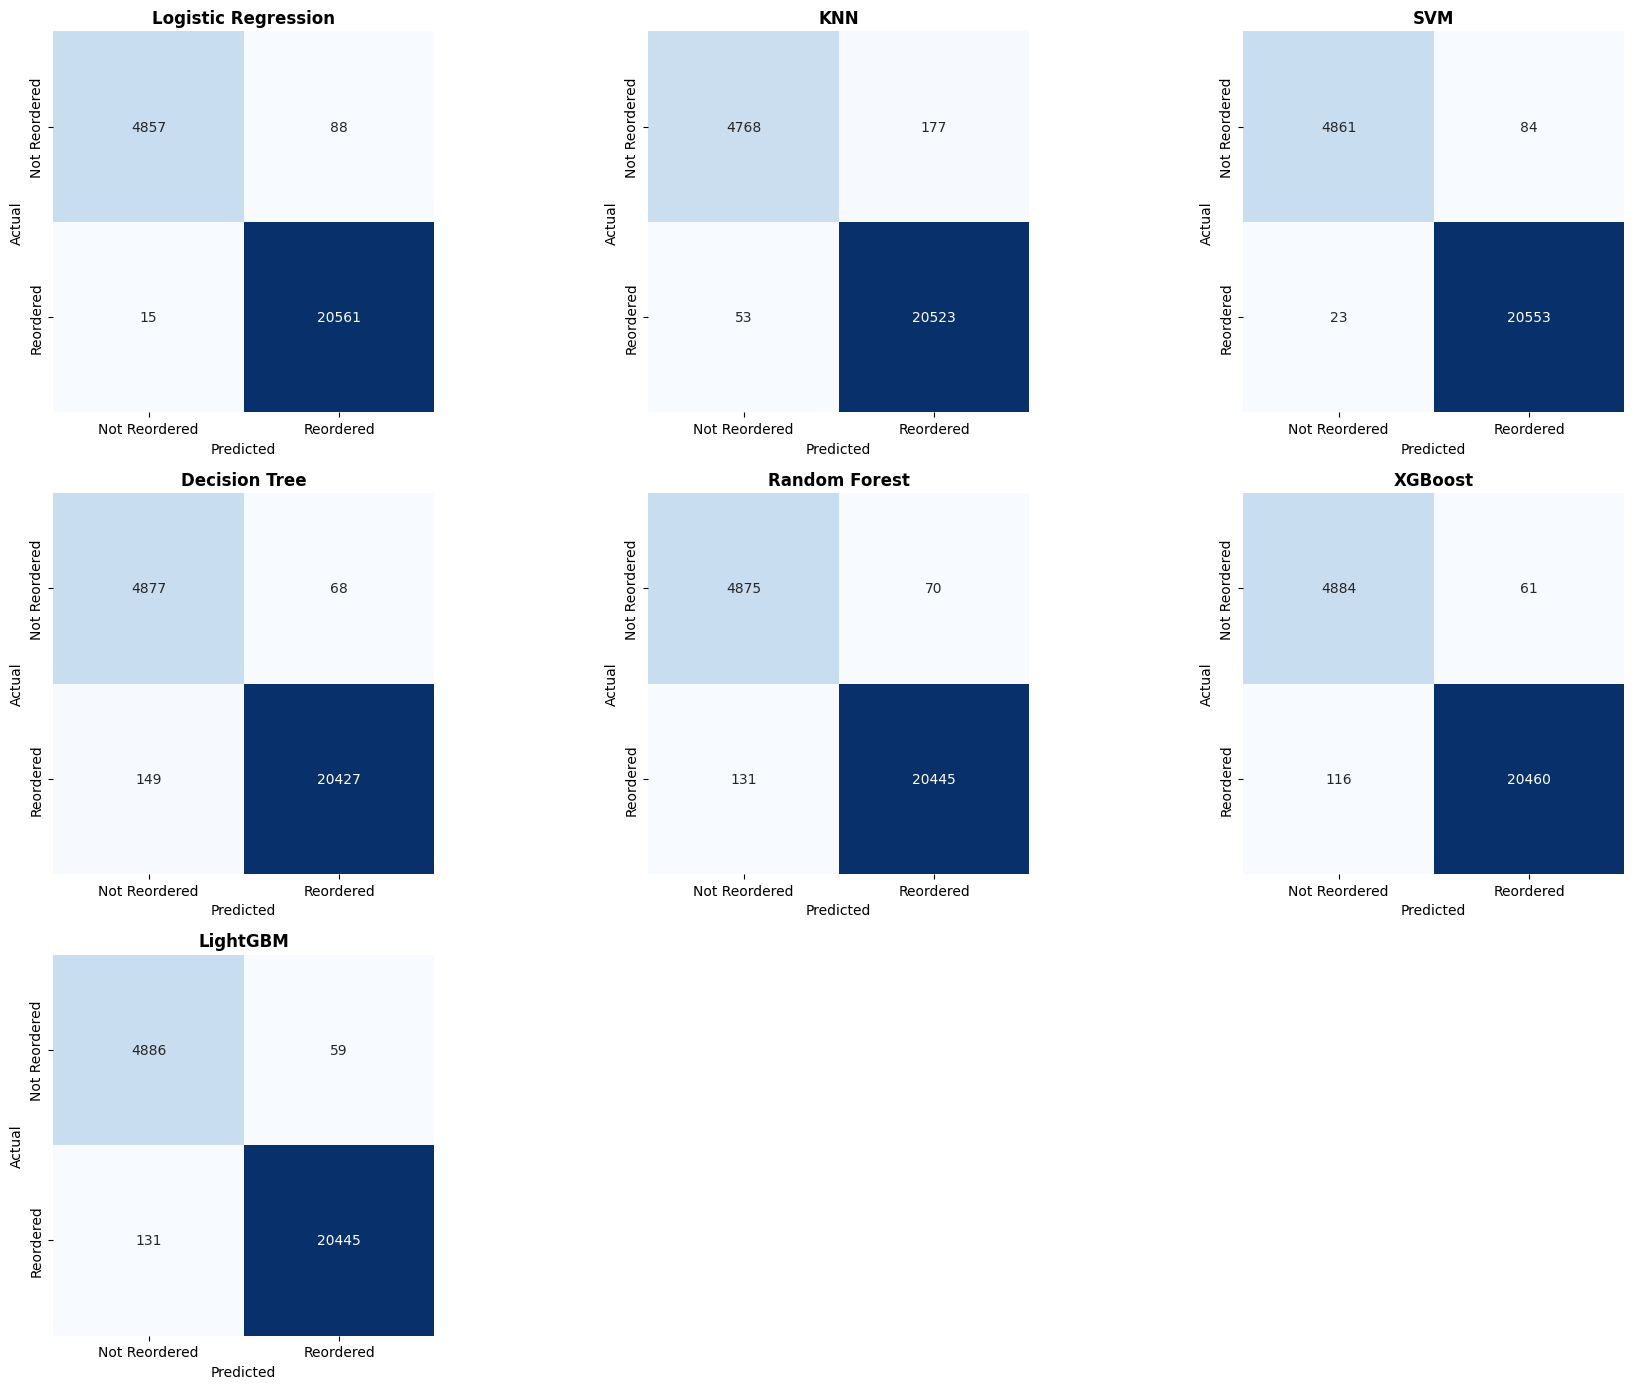


📋 Best Model: Logistic Regression
  TN: 4,857 | FP: 88
  FN: 15 | TP: 20,561


In [60]:
# Plot all models
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, (model_name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                cbar=False, square=True,
                xticklabels=['Not Reordered', 'Reordered'],
                yticklabels=['Not Reordered', 'Reordered'])
    axes[idx].set_title(model_name, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# Remove extra subplots
for idx in range(len(results), 9):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Best model details
best_model_key = list(results.keys())[metrics_df.index[0]]
print(f"\n📋 Best Model: {best_model}")
cm_best = confusion_matrix(y_test, results[best_model_key]['predictions'])
print(f"  TN: {cm_best[0,0]:,} | FP: {cm_best[0,1]:,}")
print(f"  FN: {cm_best[1,0]:,} | TP: {cm_best[1,1]:,}")

**Step 5: ROC Curves**

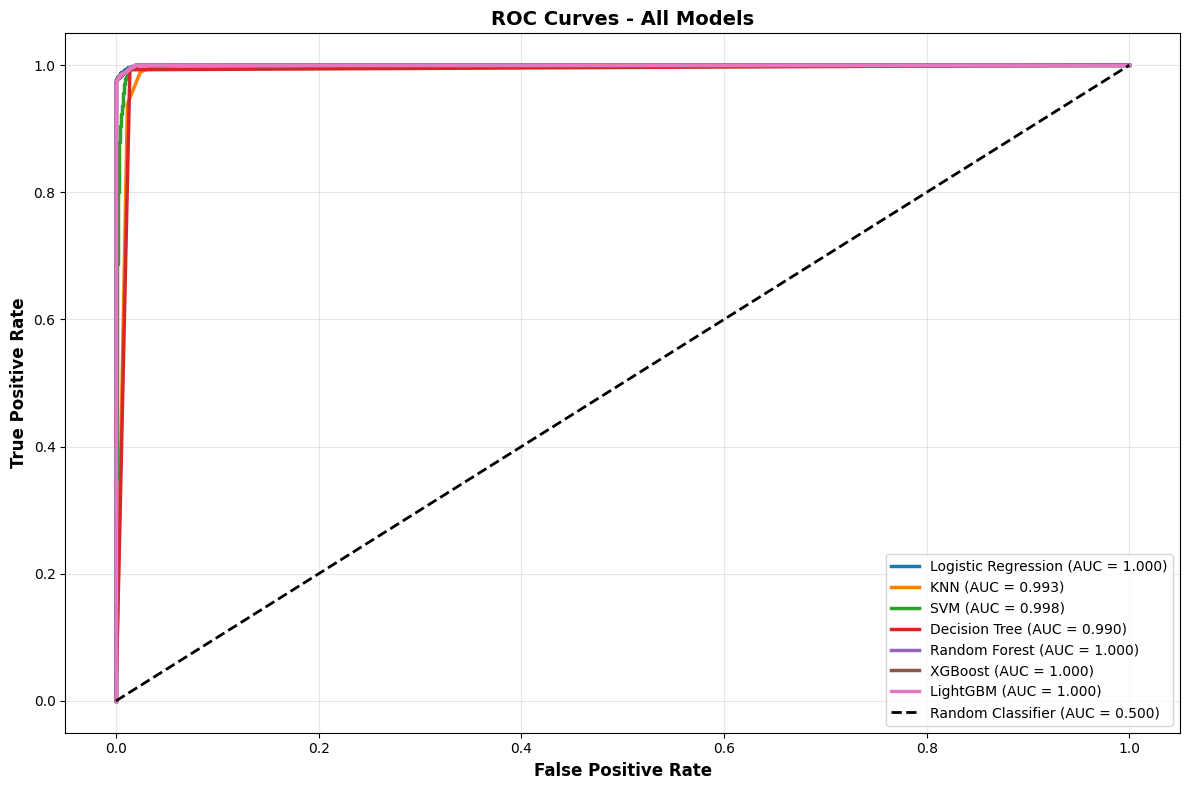

✅ ROC curves plotted!

💡 Interpretation:
  • Closer to top-left corner = Better model
  • AUC = 1.0 → Perfect classifier
  • AUC = 0.5 → Random guessing


In [61]:
plt.figure(figsize=(12, 8))

# Plot ROC curve for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

for idx, (model_name, result) in enumerate(results.items()):
    y_proba = result['probabilities']

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)

    # Plot
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})',
             linewidth=2.5, color=colors[idx])

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ ROC curves plotted!")
print("\n💡 Interpretation:")
print("  • Closer to top-left corner = Better model")
print("  • AUC = 1.0 → Perfect classifier")
print("  • AUC = 0.5 → Random guessing")

**Step 6: Precision-Recall Curves**

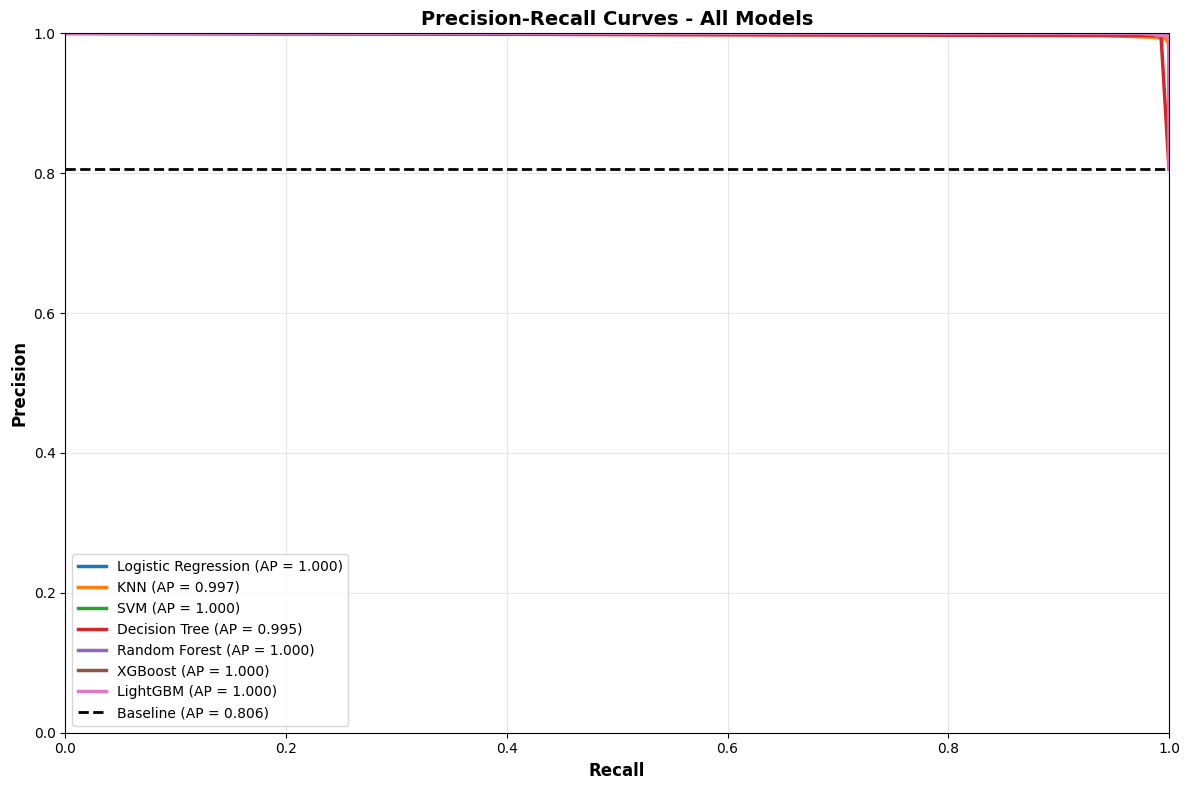

✅ Precision-Recall curves plotted!

💡 Interpretation:
  • Closer to top-right corner = Better model
  • PR curves are better for imbalanced datasets
  • Average Precision (AP) summarizes the curve


In [62]:
plt.figure(figsize=(12, 8))

# Plot PR curve for each model
for idx, (model_name, result) in enumerate(results.items()):
    y_proba = result['probabilities']

    # Calculate PR curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    ap_score = average_precision_score(y_test, y_proba)

    # Plot
    plt.plot(recall, precision, label=f'{model_name} (AP = {ap_score:.3f})',
             linewidth=2.5, color=colors[idx])

# Baseline (random classifier)
baseline = (y_test == 1).sum() / len(y_test)
plt.plot([0, 1], [baseline, baseline], 'k--', linewidth=2,
         label=f'Baseline (AP = {baseline:.3f})')

plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

print("✅ Precision-Recall curves plotted!")
print("\n💡 Interpretation:")
print("  • Closer to top-right corner = Better model")
print("  • PR curves are better for imbalanced datasets")
print("  • Average Precision (AP) summarizes the curve")

**Step 7: Feature Importance**


1️⃣ Tree-Based Models


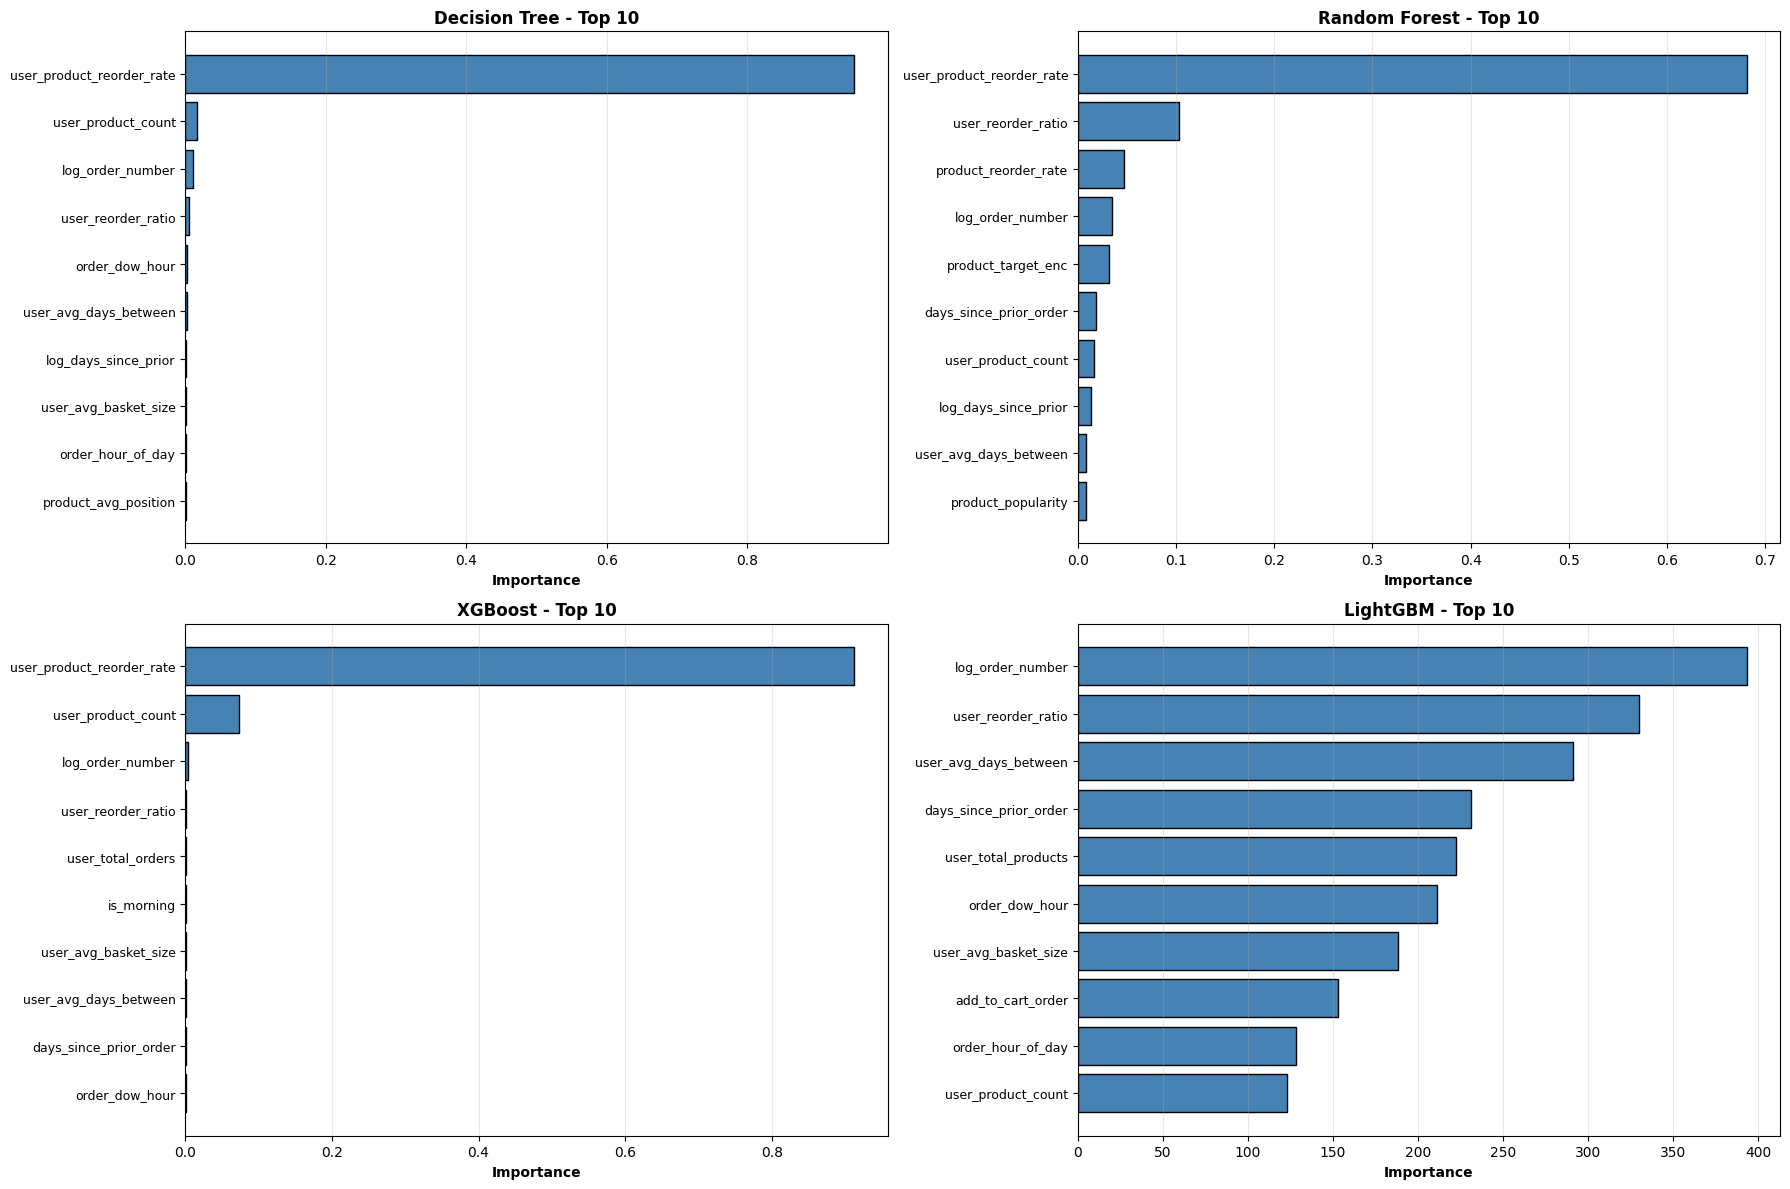


2️⃣ Logistic Regression Coefficients


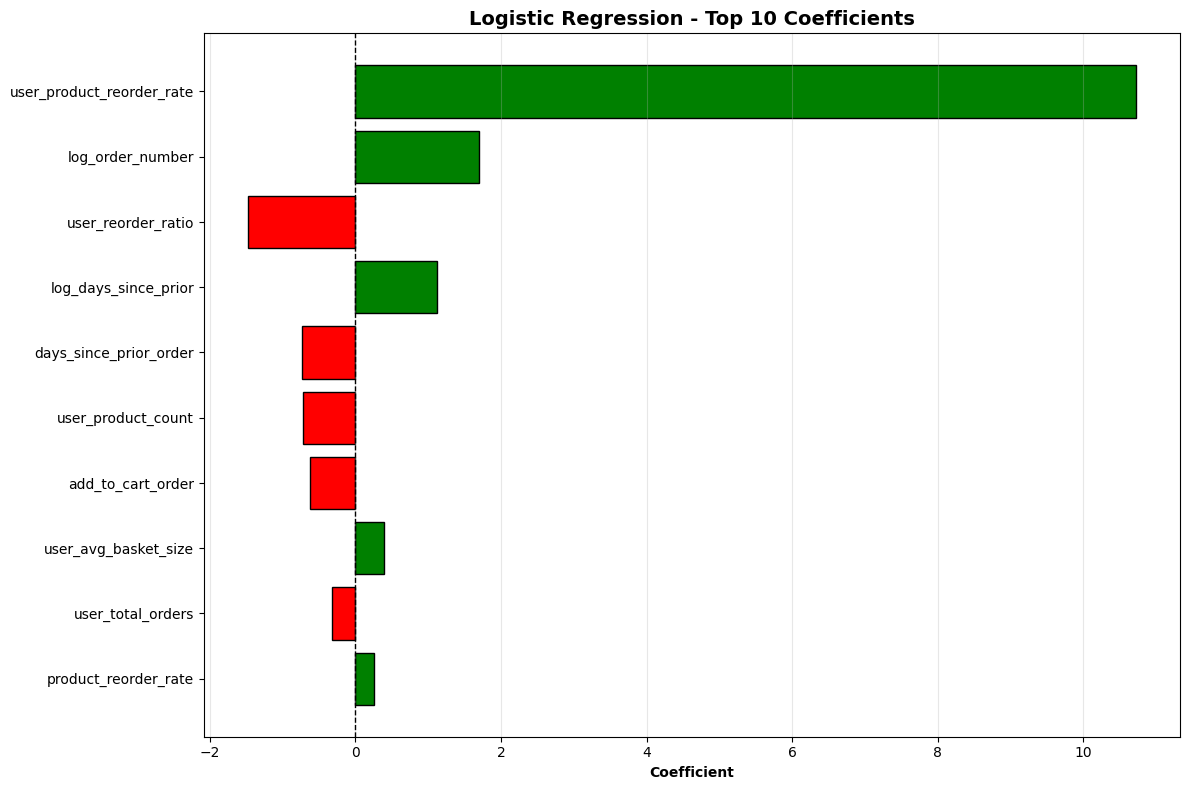

  🟢 Green = Increases reorder probability
  🔴 Red = Decreases reorder probability


In [63]:
# Get feature names
feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]

# ===== 1. TREE-BASED MODELS =====
print("\n1️⃣ Tree-Based Models")

tree_models = ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for idx, model_name in enumerate(tree_models):
    ax = axes[idx // 2, idx % 2]

    # Get top 10 important features
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': trained_models[model_name].feature_importances_
    }).nlargest(10, 'Importance')

    # Plot
    ax.barh(importance_df['Feature'], importance_df['Importance'],
            color='steelblue', edgecolor='black')
    ax.set_title(f'{model_name} - Top 10', fontsize=12, fontweight='bold')
    ax.set_xlabel('Importance', fontweight='bold')
    ax.invert_yaxis()
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


# ===== 2. LOGISTIC REGRESSION =====
print("\n2️⃣ Logistic Regression Coefficients")

lr_features = X_train_scaled.columns.tolist() if hasattr(X_train_scaled, 'columns') else feature_names
coefficients = lr_model.coef_[0]

if len(coefficients) == len(lr_features):
    # Get top 10 by absolute value
    coef_df = pd.DataFrame({
        'Feature': lr_features,
        'Coefficient': coefficients
    })
    coef_df['Abs'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.nlargest(10, 'Abs')

    # Plot
    plt.figure(figsize=(12, 8))
    colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='black')
    plt.xlabel('Coefficient', fontweight='bold')
    plt.title('Logistic Regression - Top 10 Coefficients', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("  🟢 Green = Increases reorder probability")
    print("  🔴 Red = Decreases reorder probability")
else:
    print(f"  ⚠️ Skipped (mismatch: {len(coefficients)} vs {len(lr_features)})")

**Step 8: Hyperparameter Tuning**

In [64]:
tuned_models = {}
best_params = {}

sample_size = min(100000, len(X_train))
sample_idx = np.random.choice(len(X_train), sample_size, replace=False)

# ========== 1. LOGISTIC REGRESSION ==========
print("\n1️⃣ Logistic Regression")
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    {'C': [0.1, 1, 10], 'penalty': ['l2']},
    cv=2, scoring='f1', n_jobs=-1
)
grid_lr.fit(X_train_scaled[sample_idx], y_train.iloc[sample_idx])
tuned_models['Logistic Regression'] = grid_lr.best_estimator_
best_params['Logistic Regression'] = grid_lr.best_params_
print(f"   ✅ {grid_lr.best_params_} | F1: {grid_lr.best_score_:.4f}")


# ========== 2. K-NEAREST NEIGHBORS ==========
print("\n2️⃣ K-Nearest Neighbors")
grid_knn = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    {'n_neighbors': [5, 7], 'weights': ['distance']},
    cv=2, scoring='f1', n_jobs=-1
)
knn_sample = min(30000, len(X_train_scaled))
knn_idx = np.random.choice(len(X_train_scaled), knn_sample, replace=False)
grid_knn.fit(X_train_scaled[knn_idx], y_train.iloc[knn_idx])
tuned_models['KNN'] = grid_knn.best_estimator_
best_params['KNN'] = grid_knn.best_params_
print(f"   ✅ {grid_knn.best_params_} | F1: {grid_knn.best_score_:.4f}")


# ========== 3. SVM (LINEAR) ==========
print("\n3️⃣ SVM (Linear)")
grid_svm = GridSearchCV(
    SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    {'C': [0.1, 1, 10]},
    cv=2, scoring='f1', n_jobs=-1
)
svm_sample = min(30000, len(X_train_scaled))
svm_idx = np.random.choice(len(X_train_scaled), svm_sample, replace=False)
grid_svm.fit(X_train_scaled[svm_idx], y_train.iloc[svm_idx])
tuned_models['SVM'] = grid_svm.best_estimator_
best_params['SVM'] = grid_svm.best_params_
print(f"   ✅ {grid_svm.best_params_} | F1: {grid_svm.best_score_:.4f}")


# ========== 4. DECISION TREE ==========
print("\n4️⃣ Decision Tree")
grid_dt = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    {'max_depth': [10, 15, 20], 'min_samples_split': [5, 10]},
    cv=2, scoring='f1', n_jobs=-1
)
grid_dt.fit(X_train.iloc[sample_idx], y_train.iloc[sample_idx])
tuned_models['Decision Tree'] = grid_dt.best_estimator_
best_params['Decision Tree'] = grid_dt.best_params_
print(f"   ✅ {grid_dt.best_params_} | F1: {grid_dt.best_score_:.4f}")


# ========== 5. RANDOM FOREST ==========
print("\n5️⃣ Random Forest")
random_rf = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    {'n_estimators': [50, 100], 'max_depth': [10, 15], 'min_samples_split': [5]},
    n_iter=8, cv=2, scoring='f1', n_jobs=-1, random_state=42
)
random_rf.fit(X_train.iloc[sample_idx], y_train.iloc[sample_idx])
tuned_models['Random Forest'] = random_rf.best_estimator_
best_params['Random Forest'] = random_rf.best_params_
print(f"   ✅ {random_rf.best_params_} | F1: {random_rf.best_score_:.4f}")


# ========== 6. XGBOOST ==========
print("\n6️⃣ XGBoost")
random_xgb = RandomizedSearchCV(
    XGBClassifier(scale_pos_weight=class_weight_dict[1]/class_weight_dict[0],
                  random_state=42, n_jobs=-1, eval_metric='logloss'),
    {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2]},
    n_iter=8, cv=2, scoring='f1', n_jobs=-1, random_state=42
)
random_xgb.fit(X_train.iloc[sample_idx], y_train.iloc[sample_idx])
tuned_models['XGBoost'] = random_xgb.best_estimator_
best_params['XGBoost'] = random_xgb.best_params_
print(f"   ✅ {random_xgb.best_params_} | F1: {random_xgb.best_score_:.4f}")


# ========== 7. LIGHTGBM ==========
print("\n7️⃣ LightGBM")
random_lgb = RandomizedSearchCV(
    LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1),
    {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.2]},
    n_iter=8, cv=2, scoring='f1', n_jobs=-1, random_state=42
)
random_lgb.fit(X_train.iloc[sample_idx], y_train.iloc[sample_idx])
tuned_models['LightGBM'] = random_lgb.best_estimator_
best_params['LightGBM'] = random_lgb.best_params_
print(f"   ✅ {random_lgb.best_params_} | F1: {random_lgb.best_score_:.4f}")


1️⃣ Logistic Regression
   ✅ {'C': 10, 'penalty': 'l2'} | F1: 0.9938

2️⃣ K-Nearest Neighbors
   ✅ {'n_neighbors': 7, 'weights': 'distance'} | F1: 0.9853

3️⃣ SVM (Linear)
   ✅ {'C': 0.1} | F1: 0.9920

4️⃣ Decision Tree
   ✅ {'max_depth': 10, 'min_samples_split': 10} | F1: 0.9929

5️⃣ Random Forest
   ✅ {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 15} | F1: 0.9935

6️⃣ XGBoost
   ✅ {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2} | F1: 0.9947

7️⃣ LightGBM
   ✅ {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2} | F1: 0.9945


**Step 9: Final Evaluation with Tuned Models**

📋 TUNED MODELS PERFORMANCE:


Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Logistic Regression    0.9960     0.9957  0.9993    0.9975   0.9998
1                  SVM    0.9955     0.9958  0.9986    0.9972   0.9998
2             LightGBM    0.9934     0.9969  0.9949    0.9959   0.9998
3              XGBoost    0.9930     0.9970  0.9944    0.9957   0.9998
4        Random Forest    0.9924     0.9968  0.9938    0.9953   0.9998
5        Decision Tree    0.9896     0.9973  0.9898    0.9935   0.9980
6                  KNN    0.9894     0.9899  0.9970    0.9934   0.9950


🏆 Best Model: Logistic Regression | F1: 0.9975

📊 IMPROVEMENT AFTER TUNING:


Model  Original F1  Tuned F1  Improvement (%)
0  Logistic Regression       0.9975    0.9975           0.0000
1                  KNN       0.9944    0.9934          -0.0995
2                  SVM       0.9974    0.9972          -0.0195
3        Decision Tree       0.9947    0.9935          -0.1211
4        Random Forest       0.9951    0.9953           0.0195
5              XGBoost       0.9957    0.9957          -0.0024
6             LightGBM       0.9954    0.9959           0.0541

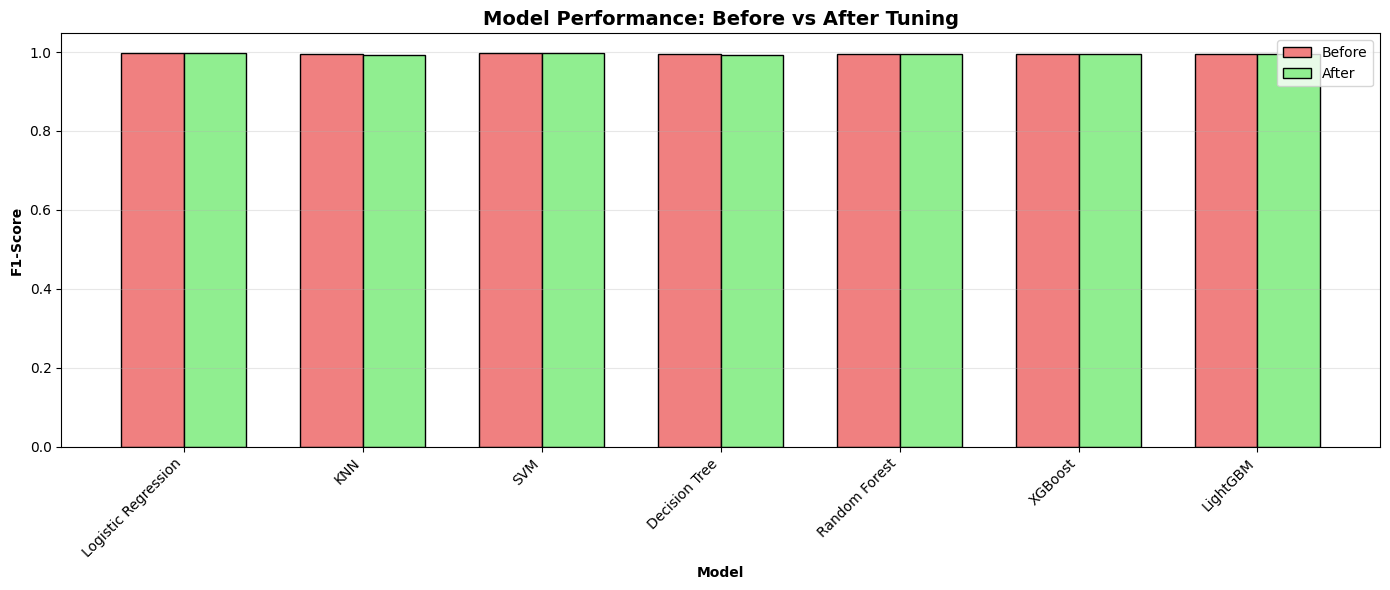


⚙️ BEST HYPERPARAMETERS:
Logistic Regression: {'C': 10, 'penalty': 'l2'}
KNN: {'n_neighbors': 7, 'weights': 'distance'}
SVM: {'C': 0.1}
Decision Tree: {'max_depth': 10, 'min_samples_split': 10}
Random Forest: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 15}
XGBoost: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
LightGBM: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}

✅ Task A (Classification) - Hyperparameter Tuning & Evaluation COMPLETE!


In [65]:
# Store tuned results
tuned_results = {}
tuned_metrics_df = pd.DataFrame()

# Evaluate each tuned model
for model_name, model in tuned_models.items():
    # Use scaled data for Logistic/KNN/SVM, unscaled for trees
    X_test_use = X_test_scaled if model_name in ['Logistic Regression', 'KNN', 'SVM'] else X_test

    # Predictions
    y_pred = model.predict(X_test_use)
    y_proba = model.predict_proba(X_test_use)[:, 1]
    tuned_results[model_name] = {'predictions': y_pred, 'probabilities': y_proba}

    # Metrics
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
    }
    tuned_metrics_df = pd.concat([tuned_metrics_df, pd.DataFrame([metrics])], ignore_index=True)

# Sort by F1
tuned_metrics_df = tuned_metrics_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("📋 TUNED MODELS PERFORMANCE:")
display(tuned_metrics_df.round(4))

best_tuned = tuned_metrics_df.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_tuned} | F1: {tuned_metrics_df.iloc[0]['F1-Score']:.4f}")

# Compare with original models
print("\n📊 IMPROVEMENT AFTER TUNING:")
comparison_df = pd.DataFrame()

for model_name in tuned_models.keys():
    original_f1 = f1_score(y_test, results[model_name]['predictions'])
    tuned_f1 = tuned_metrics_df[tuned_metrics_df['Model'] == model_name]['F1-Score'].values[0]
    improvement = ((tuned_f1 - original_f1) / original_f1) * 100

    comparison_df = pd.concat([comparison_df, pd.DataFrame([{
        'Model': model_name,
        'Original F1': original_f1,
        'Tuned F1': tuned_f1,
        'Improvement (%)': improvement
    }])], ignore_index=True)

display(comparison_df.round(4))

# Visualization: Before vs After
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Original F1'], width, label='Before',
       color='lightcoral', edgecolor='black')
ax.bar(x + width/2, comparison_df['Tuned F1'], width, label='After',
       color='lightgreen', edgecolor='black')

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('F1-Score', fontweight='bold')
ax.set_title('Model Performance: Before vs After Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Best parameters
print("\n⚙️ BEST HYPERPARAMETERS:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

print("\n✅ Task A (Classification) - Hyperparameter Tuning & Evaluation COMPLETE!")

### **Decision Boundary (Classification)**

**STEP 1: REDUCE TO 2D USING PCA**

In [66]:
# Use a sample for visualization (10,000 points)
sample_size = 10000
viz_idx = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_viz = X_train_scaled[viz_idx]
y_viz = y_train.iloc[viz_idx].values

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_viz)

print(f"   ✅ Reduced from {X_viz.shape[1]} features to 2 dimensions")
print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

   ✅ Reduced from 24 features to 2 dimensions
   Explained variance: 26.79%


**STEP 2: TRAIN MODELS ON 2D DATA**

In [67]:
models_2d = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'SVM (Linear)': SVC(kernel='linear', class_weight='balanced', random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)
}

# Train each model
for name, model in models_2d.items():
    model.fit(X_pca, y_viz)
    print(f"   ✅ {name} trained")

   ✅ Logistic Regression trained
   ✅ SVM (Linear) trained
   ✅ SVM (RBF) trained
   ✅ KNN trained
   ✅ Decision Tree trained


**STEP 3: CREATE MESH GRID**

In [68]:
h = 0.02  # Step size in mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

print(f"   ✅ Mesh grid created: {xx.shape}")

   ✅ Mesh grid created: (600, 1006)


**STEP 4: PLOT DECISION BOUNDARIES**

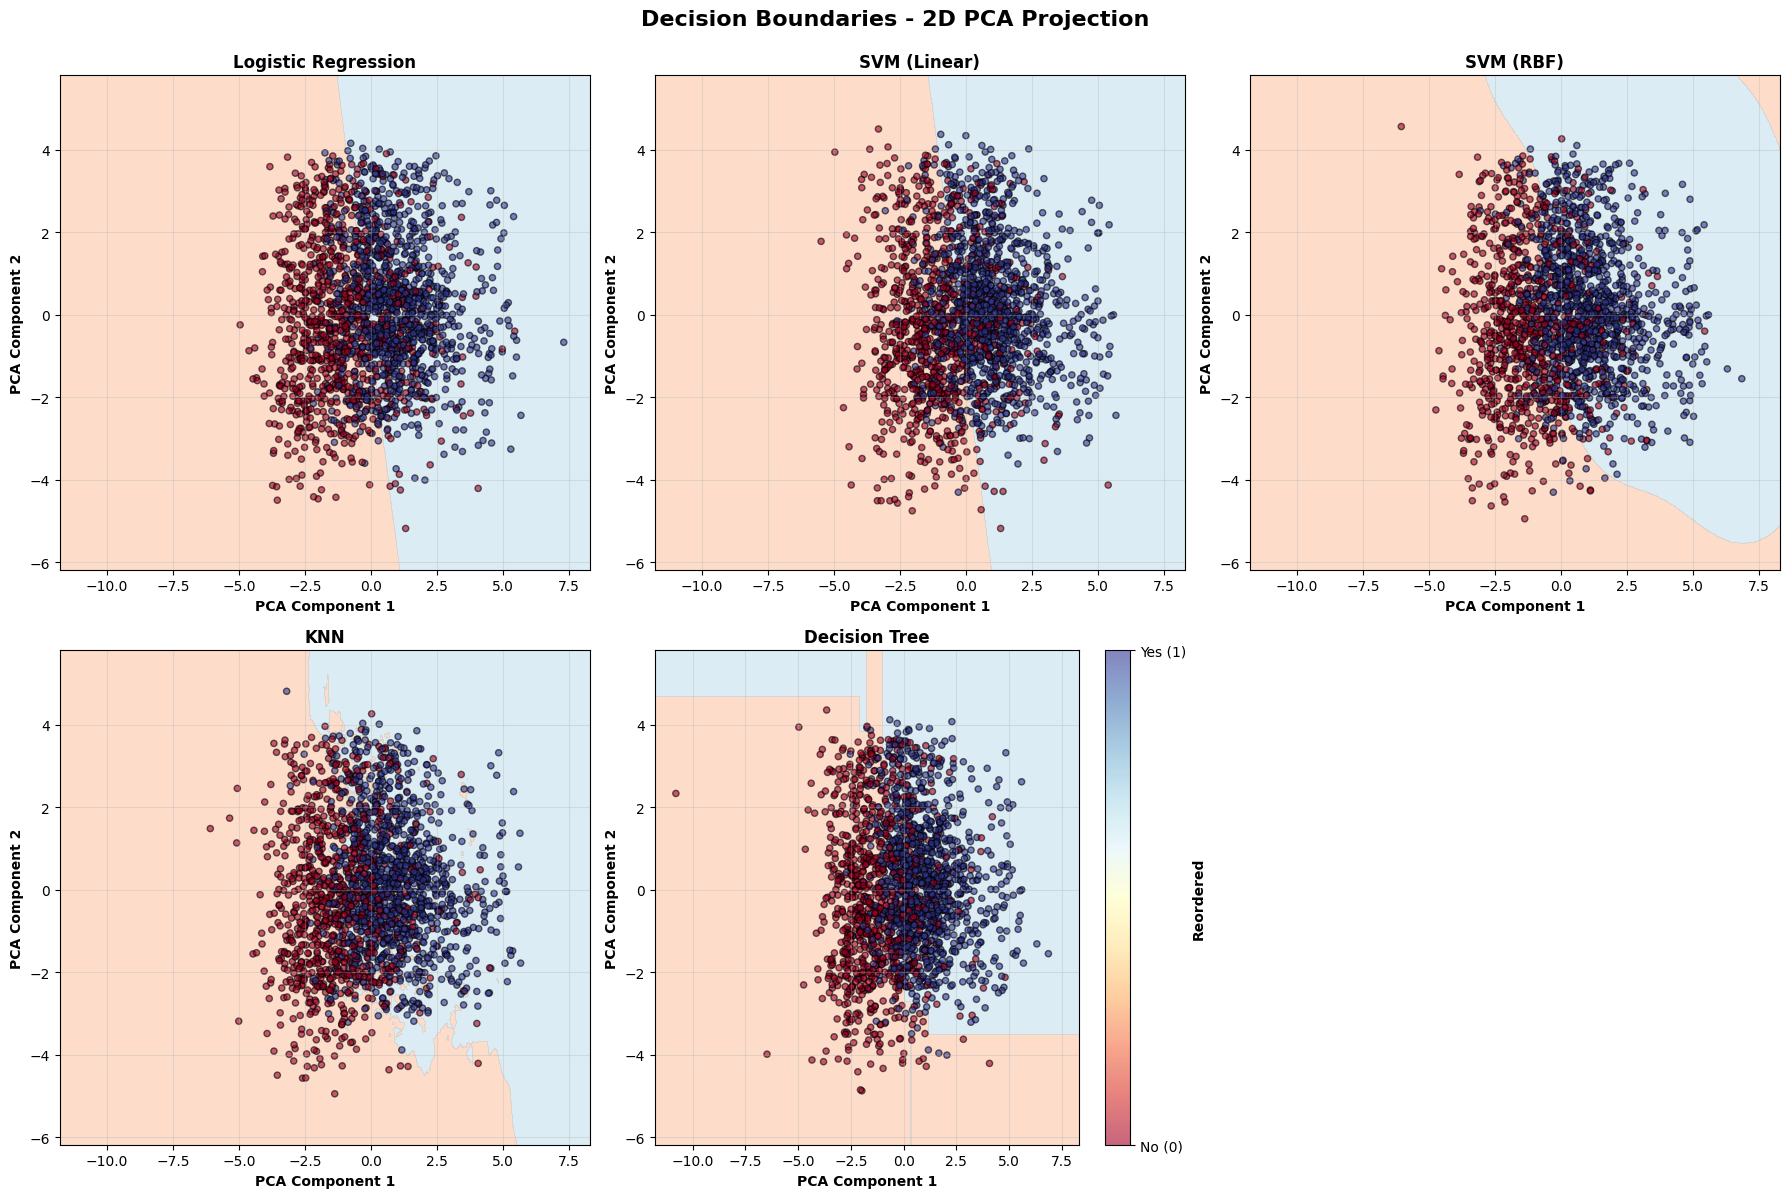

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(models_2d.items()):
    ax = axes[idx]

    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=1)

    # Plot data points (subsample for clarity)
    scatter_sample = 2000
    scatter_idx = np.random.choice(len(X_pca), scatter_sample, replace=False)
    scatter = ax.scatter(X_pca[scatter_idx, 0], X_pca[scatter_idx, 1],
                        c=y_viz[scatter_idx], cmap='RdYlBu',
                        edgecolor='black', s=20, alpha=0.6)

    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('PCA Component 1', fontweight='bold')
    ax.set_ylabel('PCA Component 2', fontweight='bold')
    ax.grid(alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[4], ticks=[0, 1])
cbar.set_label('Reordered', fontweight='bold')
cbar.ax.set_yticklabels(['No (0)', 'Yes (1)'])

plt.suptitle('Decision Boundaries - 2D PCA Projection',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

**INTERPRETATION**

In [70]:
print("\n" + "="*80)
print("💡 INTERPRETATION")
print("="*80)
print("""
📊 What the plots show:
  • Blue region = Model predicts "Not Reordered" (0)
  • Red region = Model predicts "Reordered" (1)
  • Points = Actual data (blue = 0, red = 1)

🔍 Model Comparison:
  • Logistic Regression: Linear boundary (straight line)
  • SVM (Linear): Similar to Logistic, but optimized for margin
  • SVM (RBF): Curved/circular boundaries (non-linear)
  • KNN: Irregular, bumpy boundaries (local decision-making)
  • Decision Tree: Rectangular/box-like boundaries (axis-aligned splits)

⚠️ Note:
  • We used PCA to reduce features to 2D for visualization
  • Real model performance uses ALL features, not just 2D
  • These boundaries help understand model behavior, not final predictions
""")


💡 INTERPRETATION

📊 What the plots show:
  • Blue region = Model predicts "Not Reordered" (0)
  • Red region = Model predicts "Reordered" (1)
  • Points = Actual data (blue = 0, red = 1)

🔍 Model Comparison:
  • Logistic Regression: Linear boundary (straight line)
  • SVM (Linear): Similar to Logistic, but optimized for margin
  • SVM (RBF): Curved/circular boundaries (non-linear)
  • KNN: Irregular, bumpy boundaries (local decision-making)
  • Decision Tree: Rectangular/box-like boundaries (axis-aligned splits)

⚠️ Note: 
  • We used PCA to reduce features to 2D for visualization
  • Real model performance uses ALL features, not just 2D
  • These boundaries help understand model behavior, not final predictions



###**Calibration Curves (Classification)**

**STEP 1: CALCULATE CALIBRATION FOR ALL MODELS**

In [71]:
calibration_data = {}
brier_scores = {}

for model_name, result in tuned_results.items():
    y_proba = result['probabilities']

    # Calculate calibration curve
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy='uniform')

    # Calculate Brier score (lower is better)
    brier = brier_score_loss(y_test, y_proba)

    calibration_data[model_name] = {
        'prob_true': prob_true,
        'prob_pred': prob_pred
    }
    brier_scores[model_name] = brier

    print(f"   ✅ {model_name}: Brier Score = {brier:.4f}")

   ✅ Logistic Regression: Brier Score = 0.0031
   ✅ KNN: Brier Score = 0.0104
   ✅ SVM: Brier Score = 0.0041
   ✅ Decision Tree: Brier Score = 0.0072
   ✅ Random Forest: Brier Score = 0.0058
   ✅ XGBoost: Brier Score = 0.0050
   ✅ LightGBM: Brier Score = 0.0048


**STEP 2: PLOT ALL CALIBRATION CURVES**

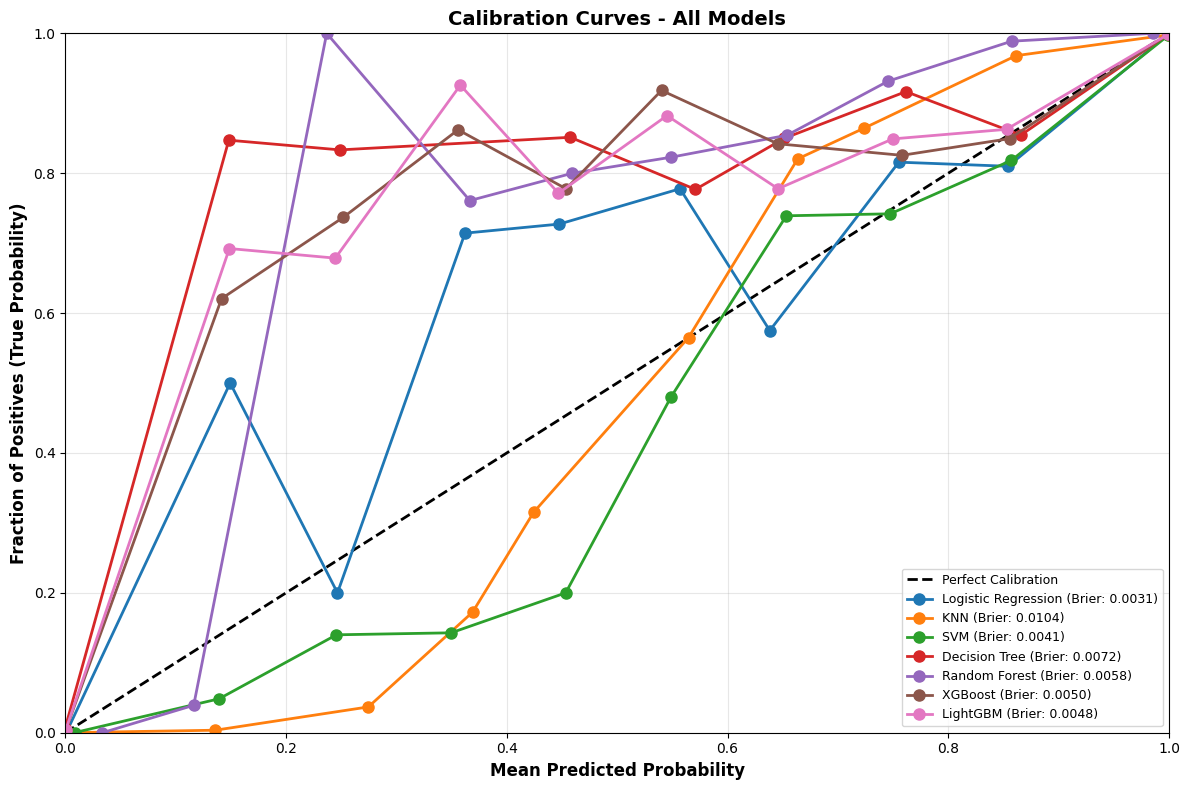

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot perfect calibration line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')

# Plot each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

for idx, (model_name, data) in enumerate(calibration_data.items()):
    ax.plot(data['prob_pred'], data['prob_true'],
            marker='o', linewidth=2, markersize=8,
            color=colors[idx % len(colors)],
            label=f"{model_name} (Brier: {brier_scores[model_name]:.4f})")

ax.set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
ax.set_ylabel('Fraction of Positives (True Probability)', fontsize=12, fontweight='bold')
ax.set_title('Calibration Curves - All Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()


**STEP 3: BRIER SCORE COMPARISON**


📋 BRIER SCORES (Lower = Better):


Model  Brier Score
0  Logistic Regression       0.0031
2                  SVM       0.0041
6             LightGBM       0.0048
5              XGBoost       0.0050
4        Random Forest       0.0058
3        Decision Tree       0.0072
1                  KNN       0.0104

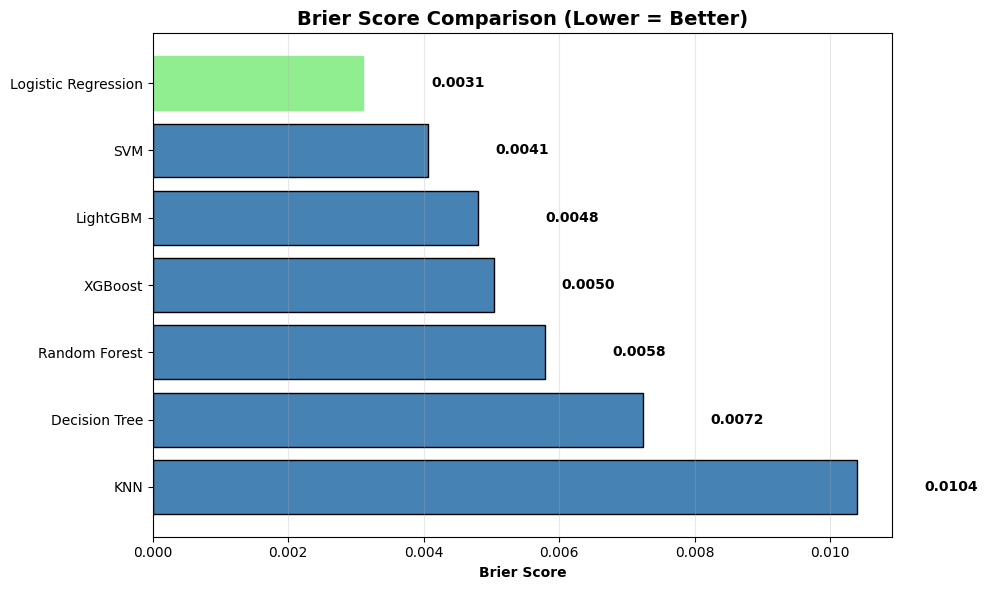

In [73]:
brier_df = pd.DataFrame({
    'Model': list(brier_scores.keys()),
    'Brier Score': list(brier_scores.values())
}).sort_values('Brier Score')

print("\n📋 BRIER SCORES (Lower = Better):")
display(brier_df.round(4))

# Plot Brier scores
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(brier_df['Model'], brier_df['Brier Score'],
               color='steelblue', edgecolor='black')

# Color the best model
bars[0].set_color('lightgreen')

ax.set_xlabel('Brier Score', fontweight='bold')
ax.set_title('Brier Score Comparison (Lower = Better)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(brier_df['Brier Score'].values):
    ax.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


**STEP 4: INDIVIDUAL CALIBRATION PLOTS**

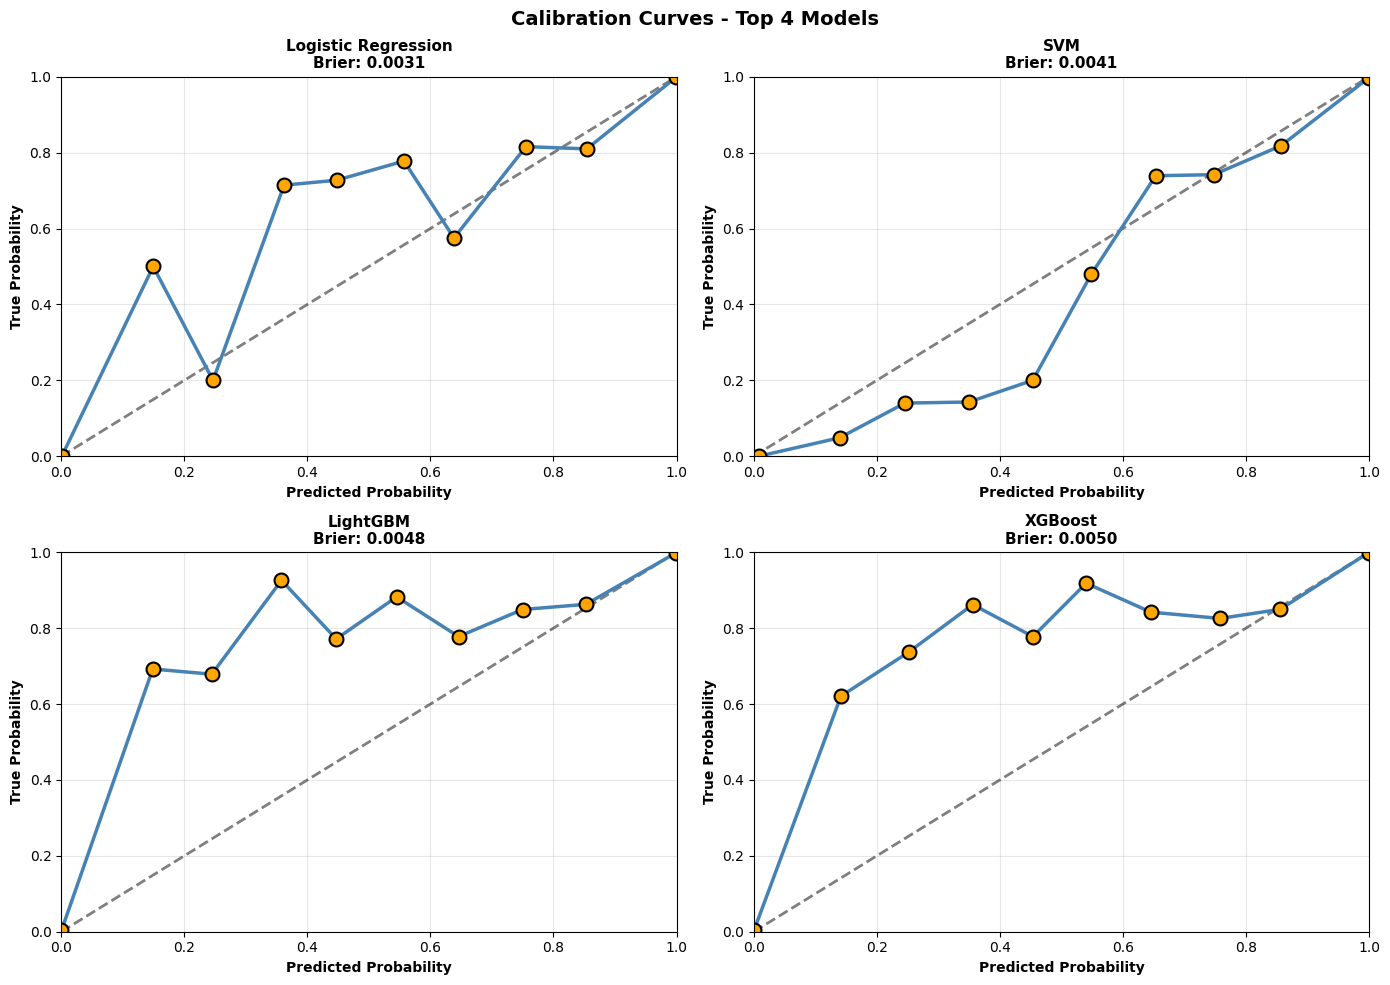

In [74]:
top_4_models = brier_df.head(4)['Model'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, model_name in enumerate(top_4_models):
    ax = axes[idx]
    data = calibration_data[model_name]

    # Plot perfect calibration
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5)

    # Plot model calibration
    ax.plot(data['prob_pred'], data['prob_true'],
            marker='o', linewidth=2.5, markersize=10,
            color='steelblue', markerfacecolor='orange',
            markeredgecolor='black', markeredgewidth=1.5)

    ax.set_xlabel('Predicted Probability', fontweight='bold')
    ax.set_ylabel('True Probability', fontweight='bold')
    ax.set_title(f'{model_name}\nBrier: {brier_scores[model_name]:.4f}',
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.suptitle('Calibration Curves - Top 4 Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


**INTERPRETATION**

In [75]:
print("\n" + "="*80)
print("💡 INTERPRETATION")
print("="*80)
print(f"""
📊 What calibration curves show:
  • Diagonal line = Perfect calibration
  • Above diagonal = Model underestimates (predicts lower prob than actual)
  • Below diagonal = Model overestimates (predicts higher prob than actual)

📈 Brier Score:
  • Measures calibration quality (0 = perfect, 1 = worst)
  • Best model: {brier_df.iloc[0]['Model']} ({brier_df.iloc[0]['Brier Score']:.4f})
  • Lower is better!

🎯 Model Calibration Quality:
""")

for model_name in brier_df['Model'].head(3):
    brier = brier_scores[model_name]
    if brier < 0.15:
        quality = "Excellent ✅"
    elif brier < 0.20:
        quality = "Good ✓"
    elif brier < 0.25:
        quality = "Fair ~"
    else:
        quality = "Needs Improvement ⚠️"
    print(f"  • {model_name}: {brier:.4f} - {quality}")


💡 INTERPRETATION

📊 What calibration curves show:
  • Diagonal line = Perfect calibration
  • Above diagonal = Model underestimates (predicts lower prob than actual)
  • Below diagonal = Model overestimates (predicts higher prob than actual)

📈 Brier Score:
  • Measures calibration quality (0 = perfect, 1 = worst)
  • Best model: Logistic Regression (0.0031)
  • Lower is better!

🎯 Model Calibration Quality:

  • Logistic Regression: 0.0031 - Excellent ✅
  • SVM: 0.0041 - Excellent ✅
  • LightGBM: 0.0048 - Excellent ✅


### **Task B: Regression (Days Until Next Order)**

**Step 1: Prepare Regression Target**

✅ Regression data ready:
   Features: (102083, 23)
   Target: days_since_prior_order

📈 Target Statistics:
count    102083.000000
mean         11.490904
std           9.355297
min           0.000000
25%           5.000000
50%           8.000000
75%          16.000000
max          30.000000
Name: days_since_prior_order, dtype: float64


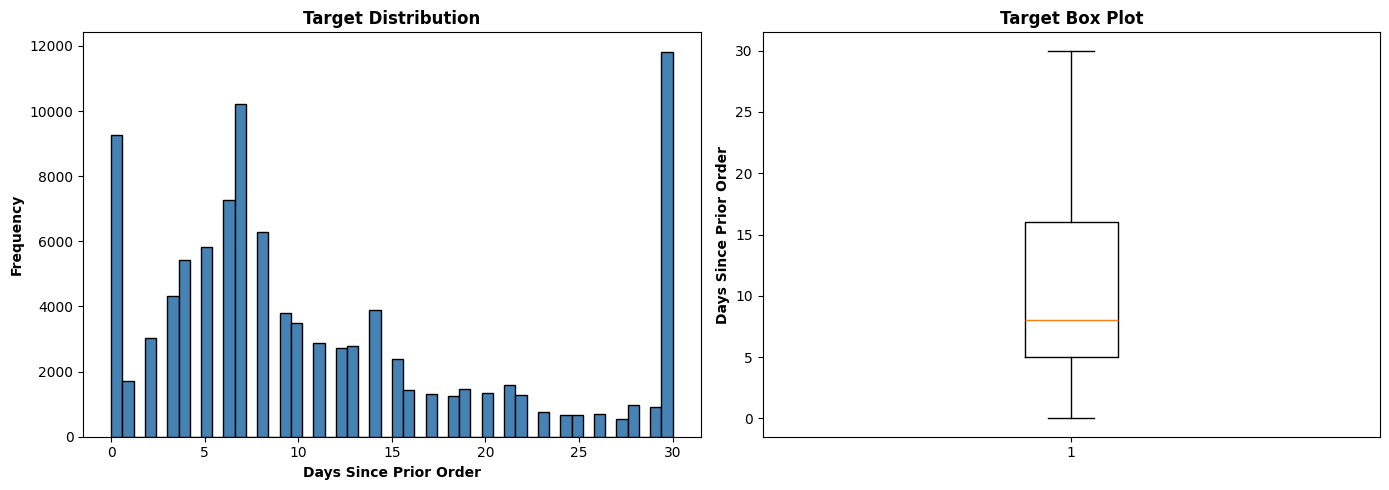

In [76]:
# train/test split
y_train_reg = train_data['days_since_prior_order']
y_test_reg = test_data['days_since_prior_order']

# Remove target from features
features_reg = [col for col in X_train.columns if col != 'days_since_prior_order']
X_train_reg = X_train[features_reg]
X_test_reg = X_test[features_reg]

# Scale for regression
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

print(f"✅ Regression data ready:")
print(f"   Features: {X_train_reg.shape}")
print(f"   Target: days_since_prior_order")
print(f"\n📈 Target Statistics:")
print(y_train_reg.describe())

# Visualize target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(y_train_reg, bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Days Since Prior Order', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Target Distribution', fontsize=12, fontweight='bold')

axes[1].boxplot(y_train_reg)
axes[1].set_ylabel('Days Since Prior Order', fontweight='bold')
axes[1].set_title('Target Box Plot', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

**Step 2: Train All Regression Models**

In [83]:
reg_results = {}
reg_trained_models = {}

# ========== 1. LINEAR REGRESSION ==========
print("\n1️⃣ Linear Regression...")
start = time.time()
lr_reg = LinearRegression()
lr_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_lr_reg = lr_reg.predict(X_test_reg_scaled)
reg_results['Linear Regression'] = y_pred_lr_reg
reg_trained_models['Linear Regression'] = lr_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")

# ========== 2. RIDGE ==========
print("\n2️⃣ Ridge Regression...")
start = time.time()
ridge_reg = Ridge(alpha=1.0, random_state=42)
ridge_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_ridge = ridge_reg.predict(X_test_reg_scaled)
reg_results['Ridge'] = y_pred_ridge
reg_trained_models['Ridge'] = ridge_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")

# ========== 3. LASSO ==========
print("\n3️⃣ Lasso Regression...")
start = time.time()
lasso_reg = Lasso(alpha=0.1, random_state=42)
lasso_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_lasso = lasso_reg.predict(X_test_reg_scaled)
reg_results['Lasso'] = y_pred_lasso
reg_trained_models['Lasso'] = lasso_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")

# ========== 4. ELASTIC NET ==========
print("\n4️⃣ Elastic Net...")
start = time.time()
elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_elastic = elastic_reg.predict(X_test_reg_scaled)
reg_results['Elastic Net'] = y_pred_elastic
reg_trained_models['Elastic Net'] = elastic_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")

# ========== 5. KNN REGRESSOR ==========
print("\n5️⃣ K-Nearest Neighbors...")
start = time.time()
knn_idx_reg = np.random.choice(len(X_train_reg_scaled), 50000, replace=False)
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_reg_scaled[knn_idx_reg], y_train_reg.iloc[knn_idx_reg])
y_pred_knn_reg = knn_reg.predict(X_test_reg_scaled)
reg_results['KNN'] = y_pred_knn_reg
reg_trained_models['KNN'] = knn_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")

# ========== 6. SVR ==========
print("\n6️⃣ Support Vector Regressor...")
start = time.time()
svr_idx = np.random.choice(len(X_train_reg_scaled), 30000, replace=False)
svr_reg = SVR(kernel='linear')
svr_reg.fit(X_train_reg_scaled[svr_idx], y_train_reg.iloc[svr_idx])
y_pred_svr = svr_reg.predict(X_test_reg_scaled)
reg_results['SVR'] = y_pred_svr
reg_trained_models['SVR'] = svr_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")

# ========== 7. DECISION TREE ==========
print("\n7️⃣ Decision Tree...")
start = time.time()
dt_reg = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_reg.fit(X_train_reg, y_train_reg)
y_pred_dt_reg = dt_reg.predict(X_test_reg)
reg_results['Decision Tree'] = y_pred_dt_reg
reg_trained_models['Decision Tree'] = dt_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")

# ========== 8. RANDOM FOREST ==========
print("\n8️⃣ Random Forest...")
start = time.time()
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_reg)
reg_results['Random Forest'] = y_pred_rf_reg
reg_trained_models['Random Forest'] = rf_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")

# ========== 9. XGBOOST ==========
print("\n9️⃣ XGBoost...")
start = time.time()
xgb_reg = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred_xgb_reg = xgb_reg.predict(X_test_reg)
reg_results['XGBoost'] = y_pred_xgb_reg
reg_trained_models['XGBoost'] = xgb_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")

# ========== 10. LIGHTGBM ==========
print("\n🔟 LightGBM...")
start = time.time()
lgb_reg = LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1)
lgb_reg.fit(X_train_reg, y_train_reg)
y_pred_lgb_reg = lgb_reg.predict(X_test_reg)
reg_results['LightGBM'] = y_pred_lgb_reg
reg_trained_models['LightGBM'] = lgb_reg
print(f"   ✅ Done in {time.time() - start:.2f}s")


1️⃣ Linear Regression...
   ✅ Done in 0.39s

2️⃣ Ridge Regression...
   ✅ Done in 0.14s

3️⃣ Lasso Regression...
   ✅ Done in 0.47s

4️⃣ Elastic Net...
   ✅ Done in 0.65s

5️⃣ K-Nearest Neighbors...
   ✅ Done in 17.47s

6️⃣ Support Vector Regressor...
   ✅ Done in 246.33s

7️⃣ Decision Tree...
   ✅ Done in 0.51s

8️⃣ Random Forest...
   ✅ Done in 24.29s

9️⃣ XGBoost...
   ✅ Done in 2.28s

🔟 LightGBM...
   ✅ Done in 1.82s


**Step 3: Evaluate All Regression Models**

In [85]:
reg_metrics_df = pd.DataFrame()

for model_name, y_pred in reg_results.items():
    mae = mean_absolute_error(y_test_reg, y_pred)
    mse = mean_squared_error(y_test_reg, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, y_pred)

    # Adjusted R² (optional but good to have)
    n = len(y_test_reg)
    p = X_test_reg.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    metrics = {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Adj R²': adj_r2
    }

    reg_metrics_df = pd.concat([reg_metrics_df, pd.DataFrame([metrics])], ignore_index=True)

# Sort by RMSE (lower is better)
reg_metrics_df = reg_metrics_df.sort_values('RMSE').reset_index(drop=True)

print("\n📋 REGRESSION MODEL COMPARISON:")
print("="*80)
display(reg_metrics_df.round(4))

best_reg_model = reg_metrics_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL: {best_reg_model}")
print(f"   RMSE: {reg_metrics_df.iloc[0]['RMSE']:.4f}")
print(f"   R²: {reg_metrics_df.iloc[0]['R²']:.4f}")


📋 REGRESSION MODEL COMPARISON:


Model     MAE    RMSE      R²  Adj R²
0      Decision Tree  0.0000  0.0000  1.0000  1.0000
1      Random Forest  0.0000  0.0000  1.0000  1.0000
2           LightGBM  0.0002  0.0002  1.0000  1.0000
3            XGBoost  0.0002  0.0002  1.0000  1.0000
4        Elastic Net  1.3952  2.1176  0.8047  0.8045
5              Lasso  1.4299  2.1502  0.7986  0.7984
6              Ridge  1.5829  2.2637  0.7768  0.7766
7  Linear Regression  1.5829  2.2637  0.7768  0.7766
8                SVR  1.5110  2.6543  0.6931  0.6928
9                KNN  2.1608  2.9870  0.6113  0.6110


🏆 BEST MODEL: Decision Tree
   RMSE: 0.0000
   R²: 1.0000


**Step 4: Visualize Model Comparison**

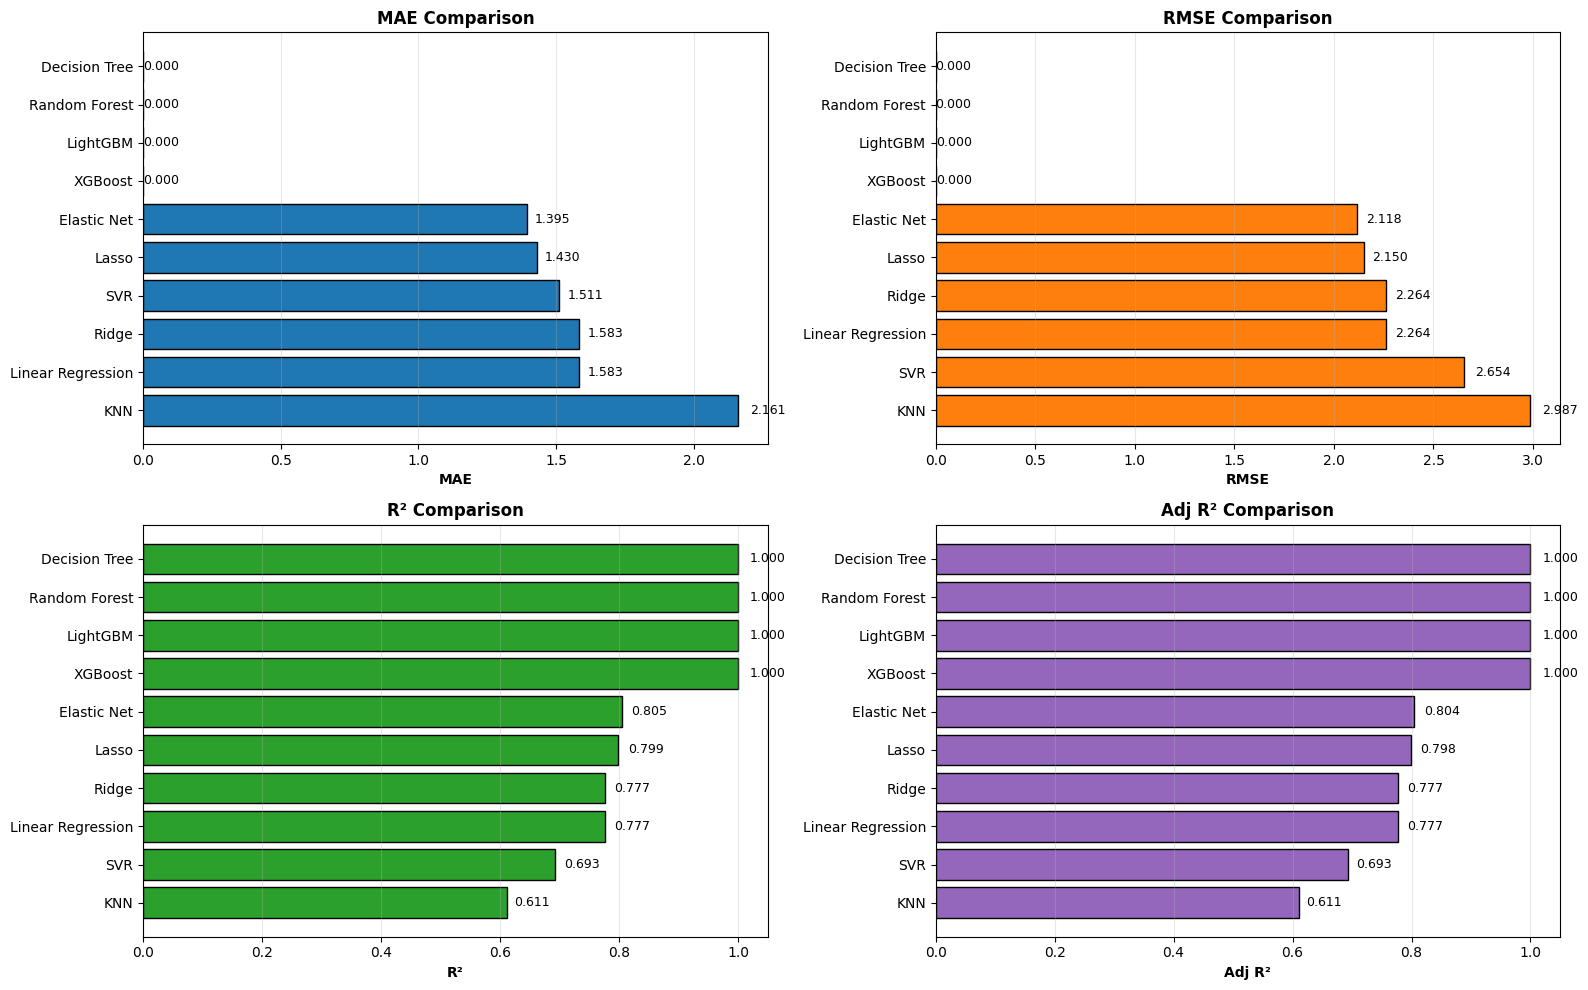

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics_to_plot = ['MAE', 'RMSE', 'R²', 'Adj R²']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx // 2, idx % 2]

    # Sort data
    if metric in ['MAE', 'RMSE']:
        sorted_data = reg_metrics_df.sort_values(metric, ascending=True)  # Lower is better
    else:
        sorted_data = reg_metrics_df.sort_values(metric, ascending=False)  # Higher is better

    ax.barh(sorted_data['Model'], sorted_data[metric], color=color, edgecolor='black')
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')

    # Add value labels
    for i, v in enumerate(sorted_data[metric]):
        ax.text(v + (v * 0.02), i, f'{v:.3f}', va='center', fontsize=9)

    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

**Step 5: Actual vs Predicted Plots**

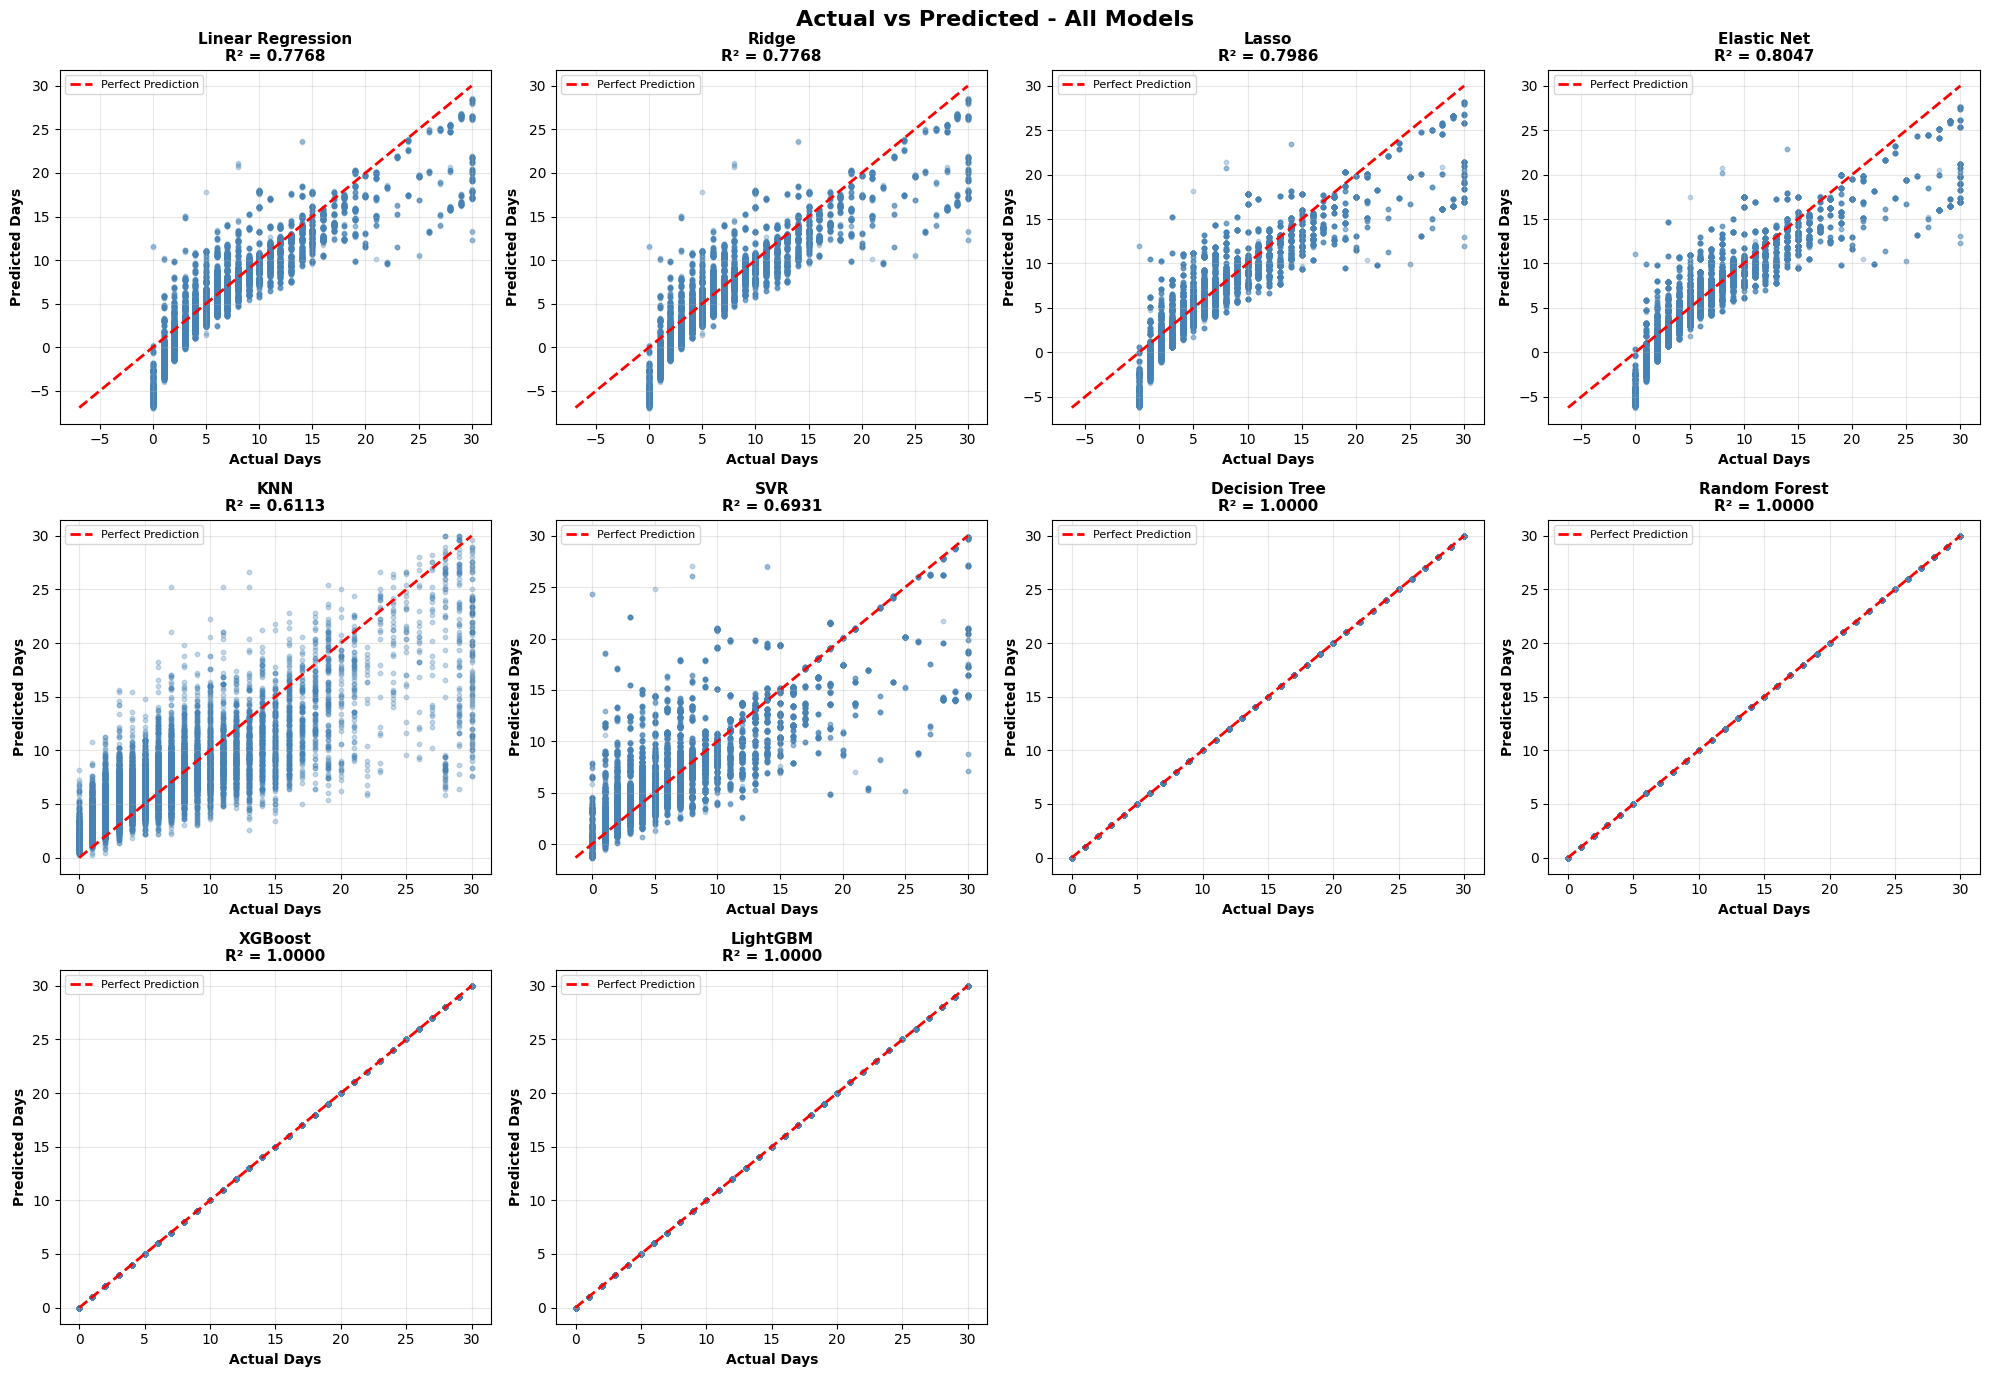

In [87]:
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

for idx, (model_name, y_pred) in enumerate(reg_results.items()):
    ax = axes[idx]

    # Scatter plot
    ax.scatter(y_test_reg, y_pred, alpha=0.3, s=10, color='steelblue')

    # Perfect prediction line
    min_val = min(y_test_reg.min(), y_pred.min())
    max_val = max(y_test_reg.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

    # Calculate R²
    r2 = r2_score(y_test_reg, y_pred)

    ax.set_xlabel('Actual Days', fontweight='bold')
    ax.set_ylabel('Predicted Days', fontweight='bold')
    ax.set_title(f'{model_name}\nR² = {r2:.4f}', fontsize=11, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(alpha=0.3)

# Remove extra subplots
for idx in range(len(reg_results), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Actual vs Predicted - All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**Step 6: Residual Analysis**

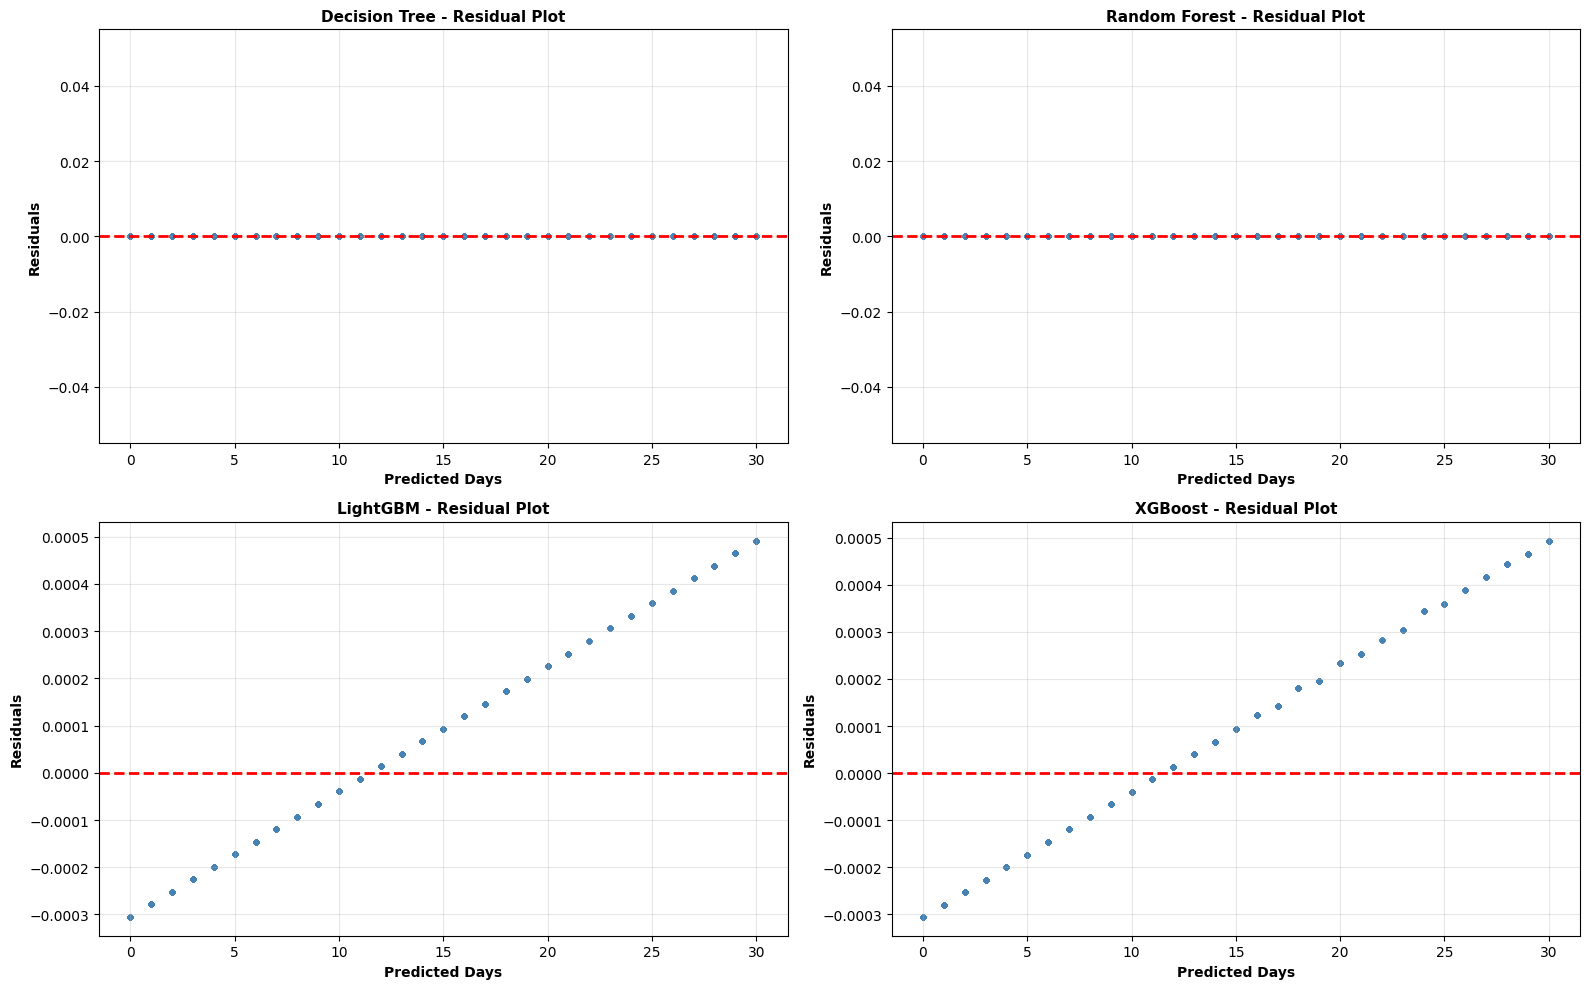

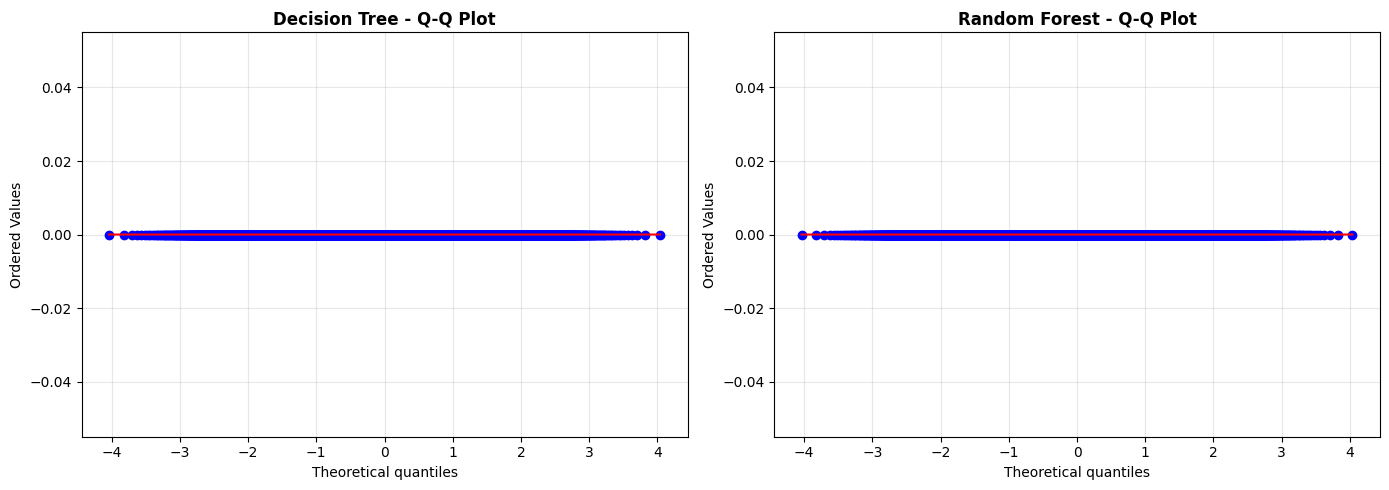

✅ Residual analysis complete!

💡 Interpretation:
  • Residuals should be randomly scattered around 0
  • Q-Q plot points should follow diagonal line for normal distribution


In [88]:
# Best 4 models
top_4_models = reg_metrics_df.head(4)['Model'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, model_name in enumerate(top_4_models):
    y_pred = reg_results[model_name]
    residuals = y_test_reg - y_pred

    ax = axes[idx]

    # Residual plot
    ax.scatter(y_pred, residuals, alpha=0.3, s=10, color='steelblue')
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicted Days', fontweight='bold')
    ax.set_ylabel('Residuals', fontweight='bold')
    ax.set_title(f'{model_name} - Residual Plot', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Q-Q Plots for top 2 models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, model_name in enumerate(top_4_models[:2]):
    y_pred = reg_results[model_name]
    residuals = y_test_reg - y_pred

    ax = axes[idx]

    # Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title(f'{model_name} - Q-Q Plot', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Residual analysis complete!")
print("\n💡 Interpretation:")
print("  • Residuals should be randomly scattered around 0")
print("  • Q-Q plot points should follow diagonal line for normal distribution")

**Step 7: Feature Importance (Regression)**

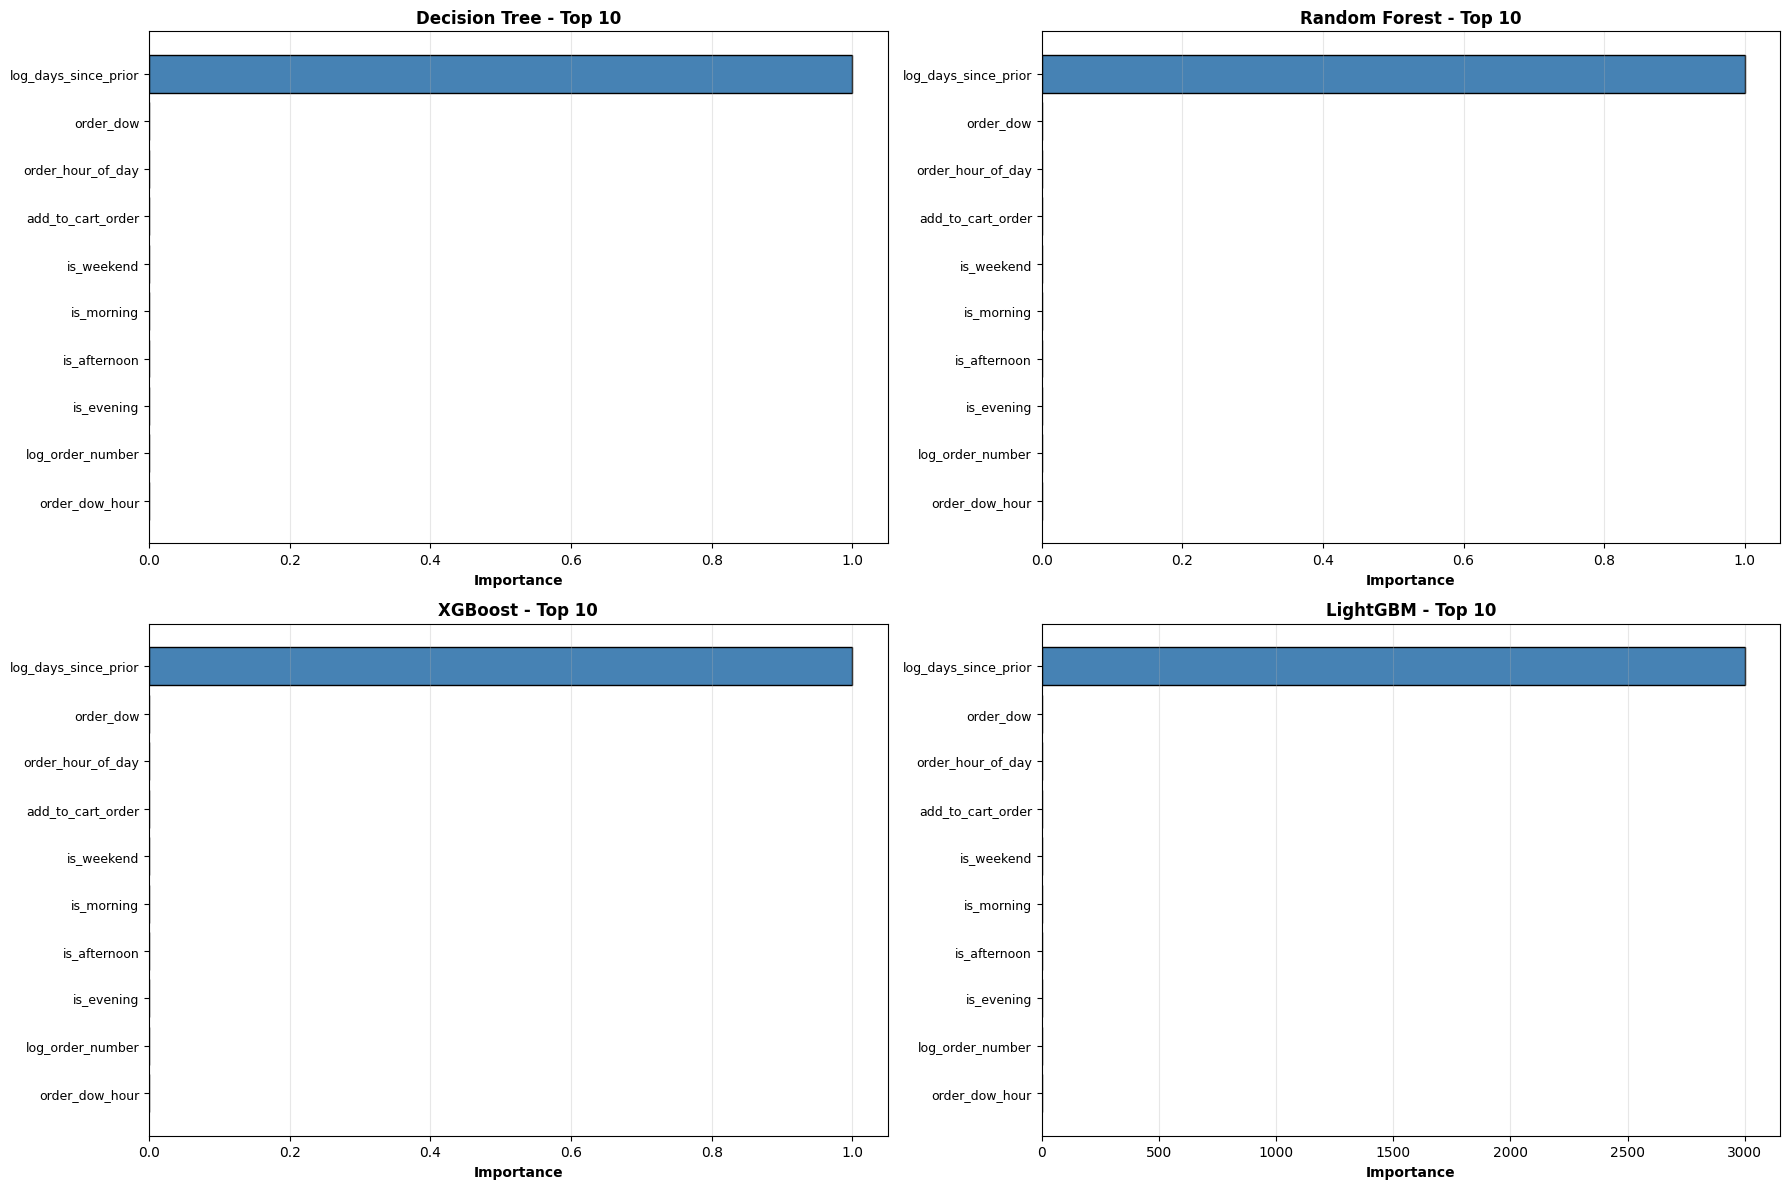


📊 Linear Regression Coefficients (Top 10):


Feature  Coefficient
13  user_avg_days_between     5.470622
7    log_days_since_prior     4.035479
12     user_reorder_ratio    -0.586416
8        log_order_number    -0.487089
0               order_dow     0.178233
3              is_weekend    -0.137634
9          order_dow_hour    -0.135297
10      user_total_orders     0.114196
1       order_hour_of_day     0.108988
2       add_to_cart_order     0.102344

In [89]:
# Get feature names
feature_names_reg = X_train_reg.columns.tolist()

# Tree-based models
tree_models_reg = ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

for idx, model_name in enumerate(tree_models_reg):
    ax = axes[idx // 2, idx % 2]

    # Get top 10 important features
    importance_df = pd.DataFrame({
        'Feature': feature_names_reg,
        'Importance': reg_trained_models[model_name].feature_importances_
    }).nlargest(10, 'Importance')

    # Plot
    ax.barh(importance_df['Feature'], importance_df['Importance'],
            color='steelblue', edgecolor='black')
    ax.set_title(f'{model_name} - Top 10', fontsize=12, fontweight='bold')
    ax.set_xlabel('Importance', fontweight='bold')
    ax.invert_yaxis()
    ax.tick_params(axis='y', labelsize=9)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Linear model coefficients
print("\n📊 Linear Regression Coefficients (Top 10):")
coef_df = pd.DataFrame({
    'Feature': feature_names_reg,
    'Coefficient': reg_trained_models['Linear Regression'].coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(10)

display(coef_df)

**Step 8: Hyperparameter Tuning (Regression)**

In [90]:
reg_tuned_models = {}
reg_best_params = {}

sample_size = min(100000, len(X_train_reg))
sample_idx = np.random.choice(len(X_train_reg), sample_size, replace=False)

# ========== 1. RIDGE ==========
print("\n1️⃣ Ridge Regression")
grid_ridge = GridSearchCV(
    Ridge(random_state=42),
    {'alpha': [0.1, 1, 10, 100]},
    cv=2, scoring='neg_mean_squared_error', n_jobs=-1
)
grid_ridge.fit(X_train_reg_scaled[sample_idx], y_train_reg.iloc[sample_idx])
reg_tuned_models['Ridge'] = grid_ridge.best_estimator_
reg_best_params['Ridge'] = grid_ridge.best_params_
print(f"   ✅ {grid_ridge.best_params_}")

# ========== 2. LASSO ==========
print("\n2️⃣ Lasso Regression")
grid_lasso = GridSearchCV(
    Lasso(random_state=42),
    {'alpha': [0.01, 0.1, 1, 10]},
    cv=2, scoring='neg_mean_squared_error', n_jobs=-1
)
grid_lasso.fit(X_train_reg_scaled[sample_idx], y_train_reg.iloc[sample_idx])
reg_tuned_models['Lasso'] = grid_lasso.best_estimator_
reg_best_params['Lasso'] = grid_lasso.best_params_
print(f"   ✅ {grid_lasso.best_params_}")

# ========== 3. ELASTIC NET ==========
print("\n3️⃣ Elastic Net")
grid_elastic = GridSearchCV(
    ElasticNet(random_state=42),
    {'alpha': [0.1, 1, 10], 'l1_ratio': [0.3, 0.5, 0.7]},
    cv=2, scoring='neg_mean_squared_error', n_jobs=-1
)
grid_elastic.fit(X_train_reg_scaled[sample_idx], y_train_reg.iloc[sample_idx])
reg_tuned_models['Elastic Net'] = grid_elastic.best_estimator_
reg_best_params['Elastic Net'] = grid_elastic.best_params_
print(f"   ✅ {grid_elastic.best_params_}")

# ========== 4. DECISION TREE ==========
print("\n4️⃣ Decision Tree")
grid_dt_reg = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    {'max_depth': [10, 15, 20], 'min_samples_split': [5, 10]},
    cv=2, scoring='neg_mean_squared_error', n_jobs=-1
)
grid_dt_reg.fit(X_train_reg.iloc[sample_idx], y_train_reg.iloc[sample_idx])
reg_tuned_models['Decision Tree'] = grid_dt_reg.best_estimator_
reg_best_params['Decision Tree'] = grid_dt_reg.best_params_
print(f"   ✅ {grid_dt_reg.best_params_}")

# ========== 5. RANDOM FOREST ==========
print("\n5️⃣ Random Forest")
random_rf_reg = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    {'n_estimators': [50, 100], 'max_depth': [10, 15, 20], 'min_samples_split': [5, 10]},
    n_iter=8, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
random_rf_reg.fit(X_train_reg.iloc[sample_idx], y_train_reg.iloc[sample_idx])
reg_tuned_models['Random Forest'] = random_rf_reg.best_estimator_
reg_best_params['Random Forest'] = random_rf_reg.best_params_
print(f"   ✅ {random_rf_reg.best_params_}")

# ========== 6. XGBOOST ==========
print("\n6️⃣ XGBoost")
random_xgb_reg = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    {'n_estimators': [50, 100], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.2]},
    n_iter=8, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
random_xgb_reg.fit(X_train_reg.iloc[sample_idx], y_train_reg.iloc[sample_idx])
reg_tuned_models['XGBoost'] = random_xgb_reg.best_estimator_
reg_best_params['XGBoost'] = random_xgb_reg.best_params_
print(f"   ✅ {random_xgb_reg.best_params_}")

# ========== 7. LIGHTGBM ==========
print("\n7️⃣ LightGBM")
random_lgb_reg = RandomizedSearchCV(
    LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    {'n_estimators': [50, 100], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.2]},
    n_iter=8, cv=2, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
random_lgb_reg.fit(X_train_reg.iloc[sample_idx], y_train_reg.iloc[sample_idx])
reg_tuned_models['LightGBM'] = random_lgb_reg.best_estimator_
reg_best_params['LightGBM'] = random_lgb_reg.best_params_
print(f"   ✅ {random_lgb_reg.best_params_}")

print("\n" + "="*80)
print("✅ ALL MODELS TUNED!")
print("="*80)

# Print best parameters
print("\n⚙️ BEST HYPERPARAMETERS:")
for model_name, params in reg_best_params.items():
    print(f"  {model_name}: {params}")


1️⃣ Ridge Regression
   ✅ {'alpha': 10}

2️⃣ Lasso Regression
   ✅ {'alpha': 0.01}

3️⃣ Elastic Net
   ✅ {'alpha': 0.1, 'l1_ratio': 0.7}

4️⃣ Decision Tree
   ✅ {'max_depth': 10, 'min_samples_split': 5}

5️⃣ Random Forest
   ✅ {'n_estimators': 50, 'min_samples_split': 10, 'max_depth': 20}

6️⃣ XGBoost
   ✅ {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}

7️⃣ LightGBM
   ✅ {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}

✅ ALL MODELS TUNED!

⚙️ BEST HYPERPARAMETERS:
  Ridge: {'alpha': 10}
  Lasso: {'alpha': 0.01}
  Elastic Net: {'alpha': 0.1, 'l1_ratio': 0.7}
  Decision Tree: {'max_depth': 10, 'min_samples_split': 5}
  Random Forest: {'n_estimators': 50, 'min_samples_split': 10, 'max_depth': 20}
  XGBoost: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}
  LightGBM: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}


**Step 9: Final Evaluation with Tuned Models**


📋 TUNED MODELS PERFORMANCE:


Model     MAE    RMSE      R²
0  Decision Tree  0.0000  0.0000  1.0000
1  Random Forest  0.0000  0.0000  1.0000
2       LightGBM  0.0000  0.0000  1.0000
3        XGBoost  0.0000  0.0000  1.0000
4    Elastic Net  1.4102  2.1307  0.8022
5          Lasso  1.5696  2.2552  0.7785
6          Ridge  1.5824  2.2633  0.7769


🏆 Best Tuned Model: Decision Tree
   RMSE: 0.0000
   R²: 1.0000

📊 IMPROVEMENT AFTER TUNING:


Model  Original RMSE  Tuned RMSE  Improvement (%)
0          Ridge         2.2637      2.2633           0.0206
1          Lasso         2.1502      2.2552          -4.8822
2    Elastic Net         2.1176      2.1307          -0.6207
3  Decision Tree         0.0000      0.0000              NaN
4  Random Forest         0.0000      0.0000              NaN
5        XGBoost         0.0002      0.0000          98.6899
6       LightGBM         0.0002      0.0000          99.9992

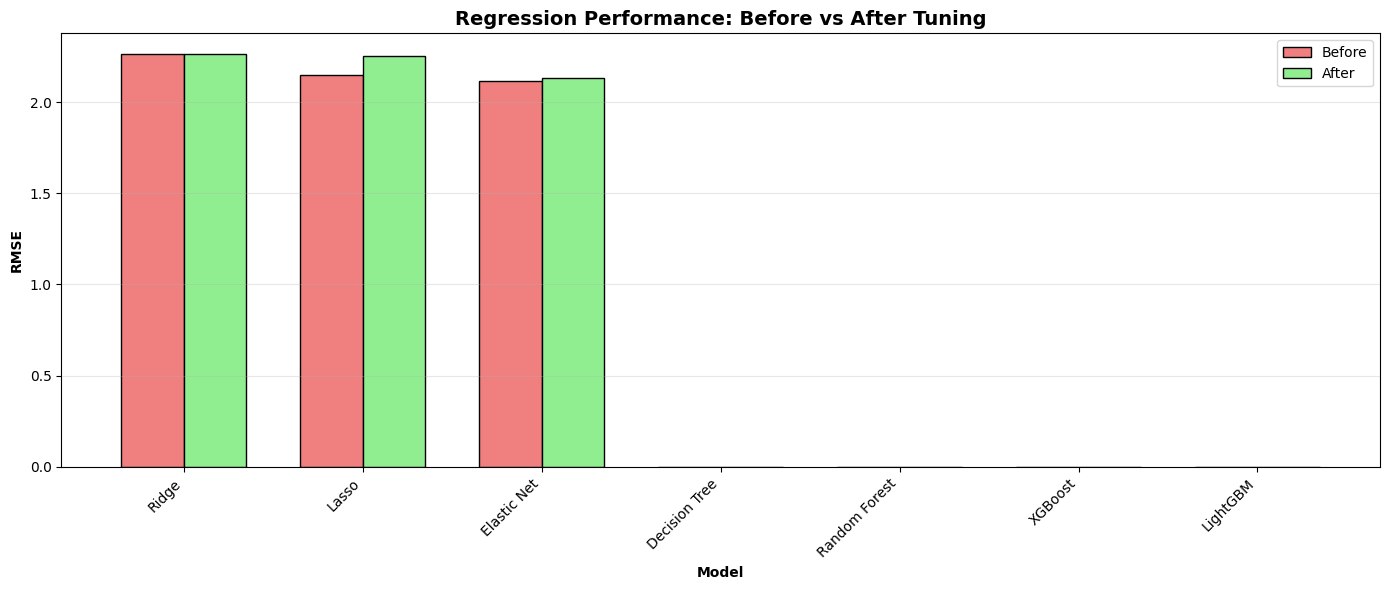

In [91]:
reg_tuned_results = {}
reg_tuned_metrics_df = pd.DataFrame()

# Evaluate each tuned model
for model_name, model in reg_tuned_models.items():
    # Use scaled data for linear models, unscaled for trees
    if model_name in ['Ridge', 'Lasso', 'Elastic Net', 'Linear Regression', 'KNN', 'SVR']:
        X_test_use = X_test_reg_scaled
    else:
        X_test_use = X_test_reg

    # Predictions
    y_pred = model.predict(X_test_use)
    reg_tuned_results[model_name] = y_pred

    # Metrics
    mae = mean_absolute_error(y_test_reg, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)

    metrics = {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    }
    reg_tuned_metrics_df = pd.concat([reg_tuned_metrics_df, pd.DataFrame([metrics])], ignore_index=True)

# Sort by RMSE
reg_tuned_metrics_df = reg_tuned_metrics_df.sort_values('RMSE').reset_index(drop=True)

print("\n📋 TUNED MODELS PERFORMANCE:")
display(reg_tuned_metrics_df.round(4))

best_tuned_reg = reg_tuned_metrics_df.iloc[0]['Model']
print(f"\n🏆 Best Tuned Model: {best_tuned_reg}")
print(f"   RMSE: {reg_tuned_metrics_df.iloc[0]['RMSE']:.4f}")
print(f"   R²: {reg_tuned_metrics_df.iloc[0]['R²']:.4f}")

# Compare with original models
print("\n📊 IMPROVEMENT AFTER TUNING:")
comparison_reg_df = pd.DataFrame()

for model_name in reg_tuned_models.keys():
    original_rmse = reg_metrics_df[reg_metrics_df['Model'] == model_name]['RMSE'].values[0]
    tuned_rmse = reg_tuned_metrics_df[reg_tuned_metrics_df['Model'] == model_name]['RMSE'].values[0]
    improvement = ((original_rmse - tuned_rmse) / original_rmse) * 100

    comparison_reg_df = pd.concat([comparison_reg_df, pd.DataFrame([{
        'Model': model_name,
        'Original RMSE': original_rmse,
        'Tuned RMSE': tuned_rmse,
        'Improvement (%)': improvement
    }])], ignore_index=True)

display(comparison_reg_df.round(4))

# Visualization: Before vs After
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(comparison_reg_df))
width = 0.35

ax.bar(x - width/2, comparison_reg_df['Original RMSE'], width, label='Before',
       color='lightcoral', edgecolor='black')
ax.bar(x + width/2, comparison_reg_df['Tuned RMSE'], width, label='After',
       color='lightgreen', edgecolor='black')

ax.set_xlabel('Model', fontweight='bold')
ax.set_ylabel('RMSE', fontweight='bold')
ax.set_title('Regression Performance: Before vs After Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_reg_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### **Learning Curves (Regression)**


🎯 Top 3 models: Decision Tree, Random Forest, LightGBM

Computing Decision Tree...
   Train: 0.0000 | Val: 0.0000 | Gap: 0.0000
Computing Random Forest...
   Train: 0.0000 | Val: 0.0000 | Gap: 0.0000
Computing LightGBM...
   Train: 0.0000 | Val: 0.0000 | Gap: 0.0000


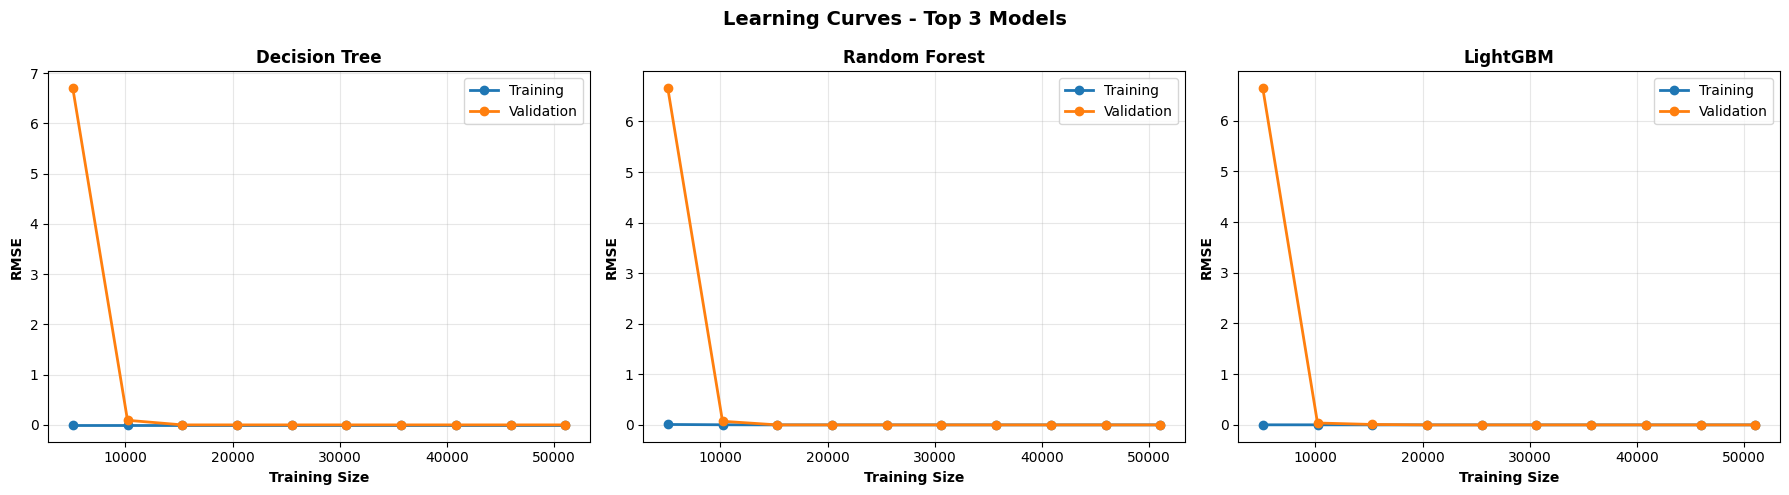


💡 Interpretation:
   • Small gap (< 0.5): Good fit ✅
   • Medium gap (0.5-1.0): Slight overfitting ⚠️
   • Large gap (> 1.0): Overfitting ❌


In [98]:
# Select top 3 models
top_3_models = reg_tuned_metrics_df.head(3)['Model'].tolist()
print(f"\n🎯 Top 3 models: {', '.join(top_3_models)}\n")

# Plot learning curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    print(f"Computing {model_name}...")

    model = reg_tuned_models[model_name]

    # Use scaled data for linear models
    X_use = X_train_reg_scaled if model_name in ['Ridge', 'Lasso', 'Elastic Net', 'KNN', 'SVR'] else X_train_reg.values

    # Compute learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_use, y_train_reg,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=2, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
    )

    # Convert to RMSE
    train_rmse = np.sqrt(-train_scores).mean(axis=1)
    val_rmse = np.sqrt(-val_scores).mean(axis=1)

    # Plot
    axes[idx].plot(train_sizes, train_rmse, 'o-', color='#1f77b4', label='Training', linewidth=2)
    axes[idx].plot(train_sizes, val_rmse, 'o-', color='#ff7f0e', label='Validation', linewidth=2)
    axes[idx].set_xlabel('Training Size', fontweight='bold')
    axes[idx].set_ylabel('RMSE', fontweight='bold')
    axes[idx].set_title(model_name, fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

    # Print results
    gap = val_rmse[-1] - train_rmse[-1]
    print(f"   Train: {train_rmse[-1]:.4f} | Val: {val_rmse[-1]:.4f} | Gap: {gap:.4f}")

plt.suptitle('Learning Curves - Top 3 Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   • Small gap (< 0.5): Good fit ✅")
print("   • Medium gap (0.5-1.0): Slight overfitting ⚠️")
print("   • Large gap (> 1.0): Overfitting ❌")

### **SHAP Explainability (Regression)**

In [100]:
# Get best model
best_model_name = reg_tuned_metrics_df.iloc[0]['Model']
best_model = reg_tuned_models[best_model_name]

print(f"\n🎯 Explaining: {best_model_name}")
print(f"   RMSE: {reg_tuned_metrics_df.iloc[0]['RMSE']:.4f}")
print(f"   R²: {reg_tuned_metrics_df.iloc[0]['R²']:.4f}")

# Prepare data
if best_model_name in ['Ridge', 'Lasso', 'Elastic Net', 'KNN', 'SVR']:
    X_explain = X_test_reg_scaled[:1000]  # Sample for speed
    X_background = X_train_reg_scaled[:100]
else:
    X_explain = X_test_reg.values[:1000]
    X_background = X_train_reg.values[:100]

feature_names = X_train_reg.columns.tolist()

print(f"\n📊 Computing SHAP values for {len(X_explain)} samples...")


🎯 Explaining: Decision Tree
   RMSE: 0.0000
   R²: 1.0000

📊 Computing SHAP values for 1000 samples...


**STEP 1: SHAP SUMMARY PLOT**

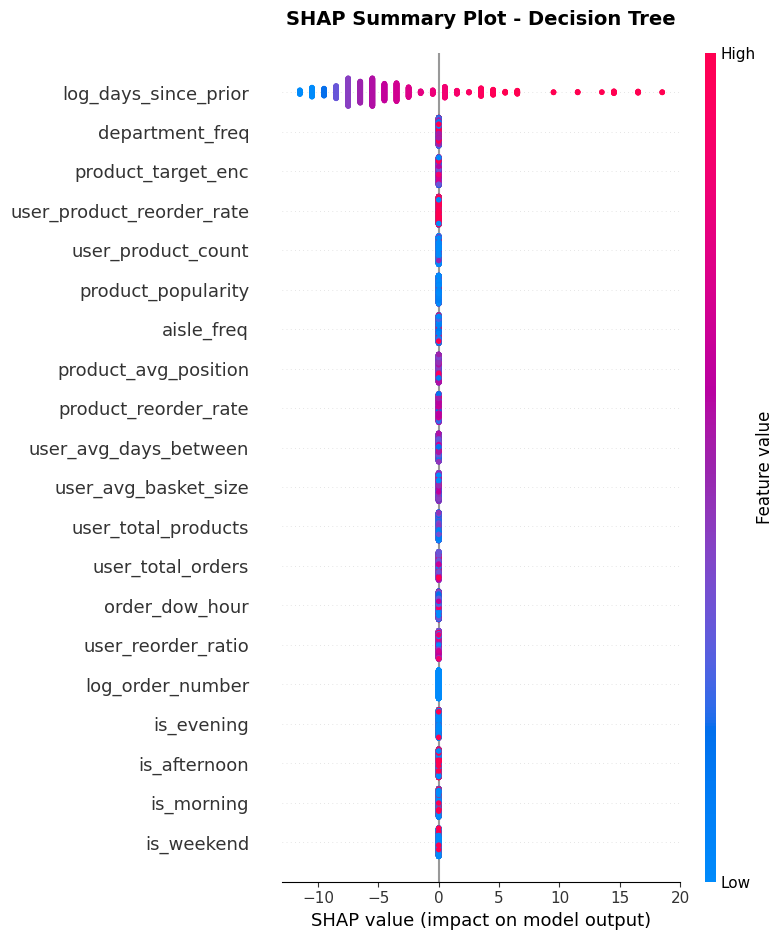

In [103]:
# Choose explainer based on model type
if best_model_name in ['Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_explain)
else:
    explainer = shap.KernelExplainer(best_model.predict, X_background)
    shap_values = explainer.shap_values(X_explain)


# Summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_explain, feature_names=feature_names, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

**STEP 2: SHAP DEPENDENCE PLOTS (TOP 3 FEATURES)**

   Top 3 features: log_days_since_prior, department_freq, product_target_enc




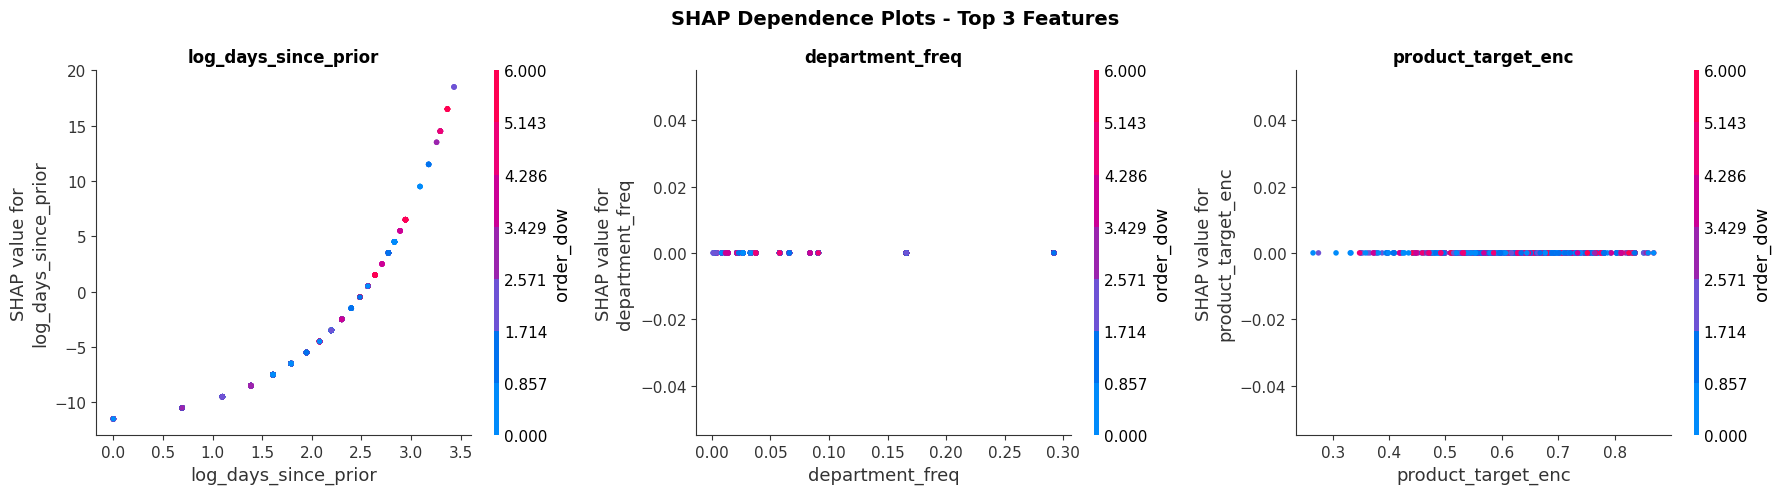

In [106]:
# Get top 3 features by mean absolute SHAP value
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_3_indices = np.argsort(mean_abs_shap)[-3:][::-1]
top_3_features = [feature_names[i] for i in top_3_indices]

print(f"   Top 3 features: {', '.join(top_3_features)}\n\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature_idx in enumerate(top_3_indices):
    feature_name = feature_names[feature_idx]

    # Dependence plot
    ax = axes[idx]
    shap.dependence_plot(
        feature_idx, shap_values, X_explain,
        feature_names=feature_names,
        ax=ax, show=False
    )
    ax.set_title(f'{feature_name}', fontsize=12, fontweight='bold')

plt.suptitle('SHAP Dependence Plots - Top 3 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**STEP 3: LOCAL EXPLANATIONS (FORCE PLOTS)**


   Best Prediction:
      Actual: 17.00 | Predicted: 17.00 | Error: 0.00


<Figure size 1400x300 with 0 Axes>

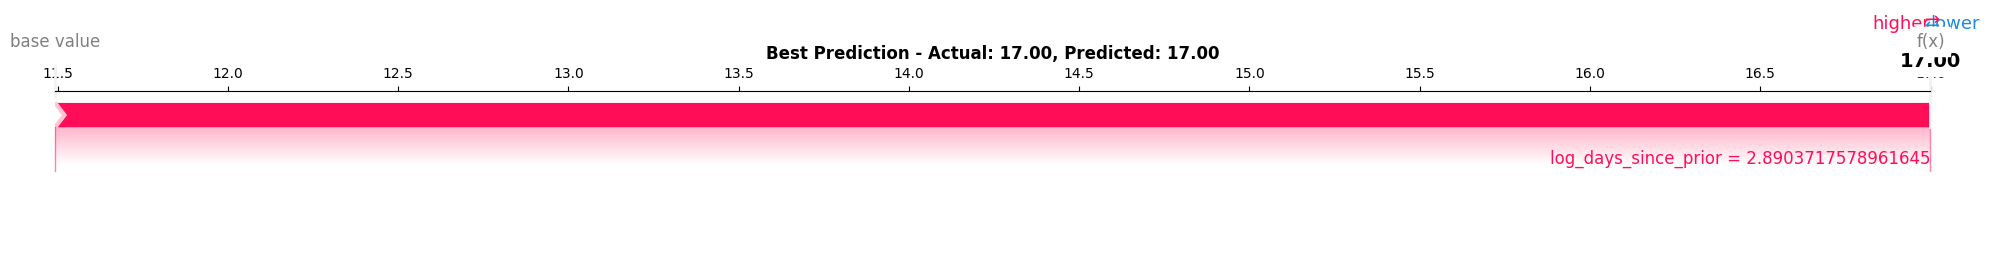


   Over-prediction:
      Actual: 17.00 | Predicted: 17.00 | Error: 0.00


<Figure size 1400x300 with 0 Axes>

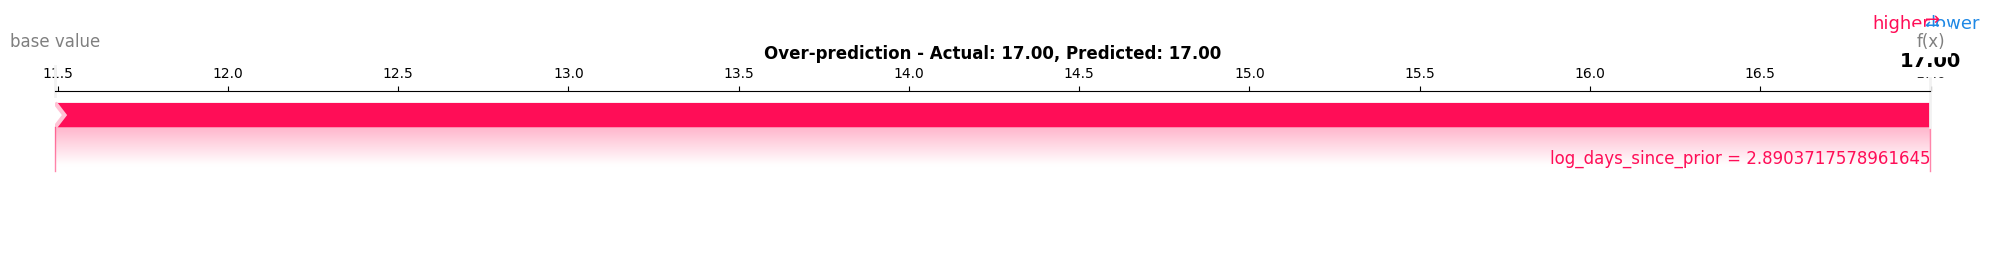


   Under-prediction:
      Actual: 17.00 | Predicted: 17.00 | Error: 0.00


<Figure size 1400x300 with 0 Axes>

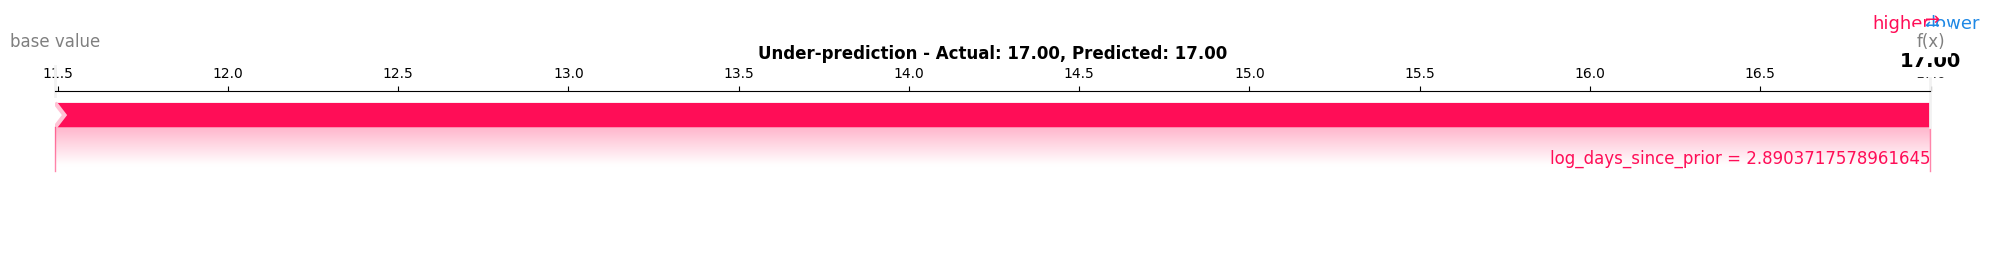

In [107]:
# Get predictions and residuals
y_pred_explain = best_model.predict(X_test_reg_scaled[:1000] if best_model_name in ['Ridge', 'Lasso', 'Elastic Net', 'KNN', 'SVR'] else X_test_reg.values[:1000])
residuals = y_test_reg.values[:1000] - y_pred_explain

# Find 3 interesting cases
best_pred_idx = np.argmin(np.abs(residuals))  # Best prediction
overpredict_idx = np.argmax(residuals)  # Largest overprediction
underpredict_idx = np.argmin(residuals)  # Largest underprediction

cases = [
    ('Best Prediction', best_pred_idx),
    ('Over-prediction', overpredict_idx),
    ('Under-prediction', underpredict_idx)
]

for case_name, idx in cases:
    actual = y_test_reg.values[idx]
    predicted = y_pred_explain[idx]
    error = actual - predicted

    print(f"\n   {case_name}:")
    print(f"      Actual: {actual:.2f} | Predicted: {predicted:.2f} | Error: {error:.2f}")

    # Force plot
    plt.figure(figsize=(14, 3))
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx],
        X_explain[idx],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.title(f'{case_name} - Actual: {actual:.2f}, Predicted: {predicted:.2f}',
              fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

**SUMMARY**

In [108]:
print("\n" + "="*80)
print("📋 SHAP ANALYSIS SUMMARY")
print("="*80)
print(f"\n🏆 Model: {best_model_name}")
print(f"\n🔝 Top 3 Most Important Features:")
for i, feat in enumerate(top_3_features, 1):
    print(f"   {i}. {feat}")

print("\n💡 Interpretation:")
print("   • Summary Plot: Shows global feature importance")
print("   • Dependence Plots: Shows how each feature affects predictions")
print("   • Force Plots: Explains individual predictions")
print("   • Red = Increases prediction | Blue = Decreases prediction")


📋 SHAP ANALYSIS SUMMARY

🏆 Model: Decision Tree

🔝 Top 3 Most Important Features:
   1. log_days_since_prior
   2. department_freq
   3. product_target_enc

💡 Interpretation:
   • Summary Plot: Shows global feature importance
   • Dependence Plots: Shows how each feature affects predictions
   • Force Plots: Explains individual predictions
   • Red = Increases prediction | Blue = Decreases prediction


# **The End of the Project**